In [1]:
lab_enc = True
ohe = True
new_features = True
hp_tune = False
balance_train = False
add_tags = True
tfidf_title = False

In [2]:
tags = []

## Column Names and Description

In [602]:
"""
Columns
The following columns are available on the training set:

accepts_mercadopago Whether the item accepts Mercado Pago
available_quantity The available stock quantity at that moment
avg_asp_item_bday Average selling price of this item over the last days
avg_asp_item_domain Average price of items of the domain this item belongs to
avg_asp_item_sel Average price of seller sales
avg_gmv_item_bday average revenue generated by the item per day
avg_gmv_item_domain_30days Average revenue generated by the items of this domain on the last month
avg_gmv_item_sel Average revenue of items of this seller
avg_gmv_seller_bday Average revenue this seller makes by day
avg_orders_item_bday Average number of orders this item has by day
avg_orders_seller_bday Average orders the seller has by day
avg_qty_orders_item_domain_30days Average number of orders a random item of this domain made on the last month
avg_qty_orders_item_sel_30days Average number of orders an item of this seller makes on the last 30 days
avg_si_item_bday Average units sold this item has by day
avg_si_item_sel_30day Average units sold of an item of this seller on the past month
avg_visits_item Average visits this item had
benefit Ignore, should be dropped
boosted Whether the item was boosted
buy_server_timestamp Timestamp of the purchase
category_id Category of this item
conversion Target variable, it is True if this print has an attributed order
cus_cust_id Buyer id
cus_cust_id_sel Seller id
date Print date
deal_print_id Unique id for the print
decimals Ignore, will be dropped
domain_id Domain id for the item
etl_version Ignore, should be dropped
free_shipping Whether the item has free shipping
fulfillment Whether the item is fulfilled by MeLi
full_name Category full name
health Item health
is_pdp Whether the click landed on a PDP
product_id Product_id of the item
item_id ID of the item, useful for debugging
listing_type_id Whether the item is gold or not
logistic_type Logistic type for the item
main_picture URL for the main item picture
offset On which page the item was rendered
original_price Price from which the discount was done
platform Which platform the user is using
price Item price
print_position Position on the page
print_server_timestamp Timestamp for the print
qty_items_dom Number of items this domain has
qty_items_sel Number of items the seller has
rn Leftover from the ETL, Discard
ROW_ID Row of the submission file
site_id Site ID
sold_quantity Number of items sold at the moment of the print
tags Tags the item had at the moment of the print
title Item title
total_asp_item_domain_30days Average selling price of the items of the domain
total_asp_item_sel_30days Average selling price of all the items the seller sold on the last 30 days
total_gmv_domain_30days Total revenue the domain made on the last 30 days
total_gmv_domain_bday total_gmv_domain_30days / 30
total_gmv_item_30days Total revenue made by the item on the lasts 30 days
total_gmv_seller Total revenue made by the seller on the last month
total_items_domain Number of items on the domain
total_items_seller Number of items the seller has
total_orders_domain_30days Total orders on the domain
total_orders_item_30days Total orders the Item had on the last 30 days
total_orders_sel_30days Total orders for the seller
total_si_domain_30days Total units sold of this domain
total_si_item_30days Total units sold of this item
total_si_sel_30days Same for the seller
total_visits_domain Total visits on this domain
total_visits_item Total visits this item had
total_visits_seller Total visits for this seller
uid session id
user_id user id
warranty Whether the item had warranty
"""

'\nColumns\nThe following columns are available on the training set:\n\naccepts_mercadopago Whether the item accepts Mercado Pago\navailable_quantity The available stock quantity at that moment\navg_asp_item_bday Average selling price of this item over the last days\navg_asp_item_domain Average price of items of the domain this item belongs to\navg_asp_item_sel Average price of seller sales\navg_gmv_item_bday average revenue generated by the item per day\navg_gmv_item_domain_30days Average revenue generated by the items of this domain on the last month\navg_gmv_item_sel Average revenue of items of this seller\navg_gmv_seller_bday Average revenue this seller makes by day\navg_orders_item_bday Average number of orders this item has by day\navg_orders_seller_bday Average orders the seller has by day\navg_qty_orders_item_domain_30days Average number of orders a random item of this domain made on the last month\navg_qty_orders_item_sel_30days Average number of orders an item of this seller 

## Librerias

In [3]:
from IPython.display import display, Markdown

import pandas as pd

import gc

import os

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler, OneHotEncoder

from sklearn.pipeline import make_pipeline

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier, HistGradientBoostingClassifier, StackingClassifier, BaggingClassifier

from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold, cross_val_score

from sklearn.metrics import roc_auc_score,  roc_curve, auc, confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, space_eval

import xgboost as xgb

import numpy as np

import matplotlib.pyplot as plt

import itertools

from tqdm import tqdm

import re

from datetime import datetime

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import nltk

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/nacho/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/nacho/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Funciones

In [4]:
def plot_roc_curves(models, model_names, X_test, y_test, ax=None):

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))

    for i in range(len(models)):
        fpr, tpr, thresholds = roc_curve(y_test, models[i].predict_proba(X_test)[:, models[i].classes_ == 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label=model_names[i] + ' (area = %0.5f)' % roc_auc)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.xlim([-0.05, 1.0])

    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')

    plt.ylabel('True Positive Rate')

    plt.title('Receiver operating characteristic example')

    # Show grid
    plt.grid(True)

    plt.legend(loc="lower right")

    plt.show()

In [5]:
def notify(title, text):
    os.system("""
              osascript -e 'display notification "{}" with title "{}"'
              """.format(text, title))

## Load Comp Data

In [6]:
comp_data = pd.read_csv("data/competition_data.csv")

In [607]:
comp_data.head()

,accepts_mercadopago,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,boosted,...,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,uid,user_id,warranty,ROW_ID
0,True,59,938.031376,2153.933091,135195.200333,3.430563,12.407860,13.691450,0.001,False,...,56717.0,17.0,25781.0,7993972,543,854813,cb5bfac7-229a-4e3e-96dd-80b2ad3972c1,NaN,Garantía de fábrica: 12 meses,NaN
1,True,37,159.826531,240.325973,19338.230000,3.142739,4.429577,4.511599,0.001,False,...,81455.0,5.0,10891.0,7821316,1789,1422288,b0f9aa19-00d5-4afd-aa77-45be7c849562,NaN,NaN,NaN
2,True,9,67.635391,86.066296,154.919333,2.633771,2.592593,2.722222,0.001,False,...,16792.0,8.0,147.0,1303909,1473,17801,fd59890a-f2c2-4282-b2ee-c68f25e20697,151157147.0,NaN,NaN
3,True,12,92.085756,332.848400,554.747333,3.280069,12.620000,12.840000,0.001,False,...,1988.0,14.0,642.0,139419,7473,44336,72340acf-2a1c-4214-a604-132e0cb56939,NaN,Garantía de fábrica: 90 días,NaN
4,True,5,156.905222,955.997475,3154.791667,2.737876,3.666667,4.363636,0.001,False,...,8707.0,32.0,432.0,209373,416,46206,84da1314-814c-4d4f-be23-3de9ea1da4b6,NaN,Garantía del vendedor: 90 días,NaN


In [608]:
comp_data.describe()

,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,conversion,health,...,total_orders_item_30days,total_orders_sel_30days,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,user_id,ROW_ID
count,199972.000000,195607.000000,195607.000000,195607.000000,195607.000000,195607.000000,195607.000000,199971.000000,180761.000000,199972.000000,...,195607.000000,195607.000000,195607.000000,195607.000000,195607.000000,1.999720e+05,199972.000000,1.999720e+05,1.783750e+05,19211.000000
mean,2142.683766,333.141264,1160.099822,10815.338962,4.385187,13.542561,18.286236,0.000976,0.092631,0.809401,...,65.176297,3941.158614,29197.693135,88.487667,5238.731257,2.170257e+06,5571.603790,2.542803e+05,2.246094e+08,9605.000000
std,11326.386712,492.836951,4284.246365,26377.753704,2.768258,25.645743,33.648431,0.000154,0.289915,0.146368,...,129.610777,5145.727129,49694.994203,220.606860,6809.183739,3.545316e+06,12108.897095,3.458552e+05,1.474232e+08,5545.882346
min,0.000000,4.909057,4.773333,0.660000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,4.000000,1.000000,2.000000,3.160000e+02,1.000000,1.100000e+01,1.610000e+02,0.000000
25%,19.000000,86.729688,143.184865,793.281667,2.876796,4.188679,4.916896,0.001000,0.000000,0.770000,...,6.000000,718.000000,3938.000000,7.000000,943.000000,1.899680e+05,407.000000,4.804600e+04,1.053200e+08,4802.500000
50%,67.000000,169.234106,262.266733,2733.067000,3.639912,6.768293,8.875000,0.001000,0.000000,0.810000,...,20.000000,2102.000000,11660.000000,24.000000,2713.000000,5.613990e+05,1496.000000,1.263900e+05,1.976426e+08,9605.000000
75%,371.000000,319.281502,675.989333,9217.855667,5.066384,13.403873,18.558559,0.001000,0.000000,0.900000,...,63.000000,5017.000000,38725.000000,80.000000,6455.000000,2.007145e+06,5248.000000,2.817150e+05,3.202613e+08,14407.500000
max,99999.000000,3778.257881,57282.961233,244988.442667,38.148629,258.363636,465.500000,0.001000,1.000000,1.000000,...,1853.000000,36492.000000,505258.000000,8269.000000,56189.000000,1.591114e+07,195413.000000,2.938795e+06,1.000014e+09,19210.000000


In [609]:
display(
    Markdown(
        "\n".join(
            [
                #"- **{}** ({}) \n\n {}".format(col, dtype, comp_data[col].value_counts()) for col, dtype in
                #"- **{}** ({})".format(col, dtype) for col, dtype in
                #zip(comp_data.columns, comp_data.dtypes)
                "- **{}**".format(col) for col in comp_data.columns
            ]
        )
    )
)

- **accepts_mercadopago**
- **available_quantity**
- **avg_gmv_item_domain_30days**
- **avg_gmv_item_sel**
- **avg_gmv_seller_bday**
- **avg_qty_orders_item_domain_30days**
- **avg_qty_orders_item_sel_30days**
- **avg_si_item_sel_30day**
- **benefit**
- **boosted**
- **category_id**
- **conversion**
- **date**
- **deal_print_id**
- **domain_id**
- **etl_version**
- **free_shipping**
- **fulfillment**
- **full_name**
- **health**
- **is_pdp**
- **product_id**
- **item_id**
- **listing_type_id**
- **logistic_type**
- **main_picture**
- **offset**
- **original_price**
- **platform**
- **price**
- **print_position**
- **print_server_timestamp**
- **qty_items_dom**
- **qty_items_sel**
- **site_id**
- **sold_quantity**
- **tags**
- **title**
- **total_asp_item_domain_30days**
- **total_asp_item_sel_30days**
- **total_gmv_domain_bday**
- **total_gmv_item_30days**
- **total_items_domain**
- **total_items_seller**
- **total_orders_domain_30days**
- **total_orders_item_30days**
- **total_orders_sel_30days**
- **total_si_domain_30days**
- **total_si_item_30days**
- **total_si_sel_30days**
- **total_visits_domain**
- **total_visits_item**
- **total_visits_seller**
- **uid**
- **user_id**
- **warranty**
- **ROW_ID**

## Data Cleaning

In [7]:
#comp_data = pd.read_csv("data/competition_data.csv")
comp_data = comp_data.drop(
        columns=[
            "accepts_mercadopago", # Todos tienen mercadopago
            "boosted", # Ninguno
            "avg_qty_orders_item_domain_30days",
            "avg_qty_orders_item_sel_30days",
            "avg_si_item_sel_30day",
            #"date",
            "deal_print_id",
            "etl_version",
            "full_name",
            "main_picture",
            "print_server_timestamp",
            #"title",
            "uid",
            #"user_id",
            "avg_gmv_item_domain_30days",
            #"avg_gmv_item_sel",
            "avg_gmv_seller_bday",
            #"qty_items_dom",
            #"category_id",
            #"domain_id",
            #"product_id",
            #"listing_type_id",
            # "logistic_type",
            "site_id",
            #"tags",
            "total_asp_item_sel_30days", 
            "total_gmv_domain_bday", 
            #"total_items_domain", 
            "total_items_seller", 
            "total_orders_domain_30days", 
            "total_orders_item_30days", 
            "total_orders_sel_30days", 
            "total_si_sel_30days", 
            #"total_visits_domain", 
            #"total_visits_item", 
            #"total_visits_seller",
            "total_asp_item_domain_30days",
            "total_gmv_item_30days",
            "total_si_domain_30days",
            "total_si_item_30days",
            # "warranty",
            # "offset",
        ]
    )

In [8]:
display(
    Markdown(
        "\n".join(
            [
                #"- **{}** ({}) \n\n {}".format(col, dtype, comp_data[col].value_counts()) for col, dtype in
                #"- **{}** ({})".format(col, dtype) for col, dtype in
                #zip(comp_data.columns, comp_data.dtypes)
                "- **{}**".format(col) for col in comp_data.columns
            ]
        )
    )
)

- **available_quantity**
- **avg_gmv_item_sel**
- **benefit**
- **category_id**
- **conversion**
- **date**
- **domain_id**
- **free_shipping**
- **fulfillment**
- **health**
- **is_pdp**
- **product_id**
- **item_id**
- **listing_type_id**
- **logistic_type**
- **offset**
- **original_price**
- **platform**
- **price**
- **print_position**
- **qty_items_dom**
- **qty_items_sel**
- **sold_quantity**
- **tags**
- **title**
- **total_items_domain**
- **total_visits_domain**
- **total_visits_item**
- **total_visits_seller**
- **user_id**
- **ROW_ID**

In [10]:
# # For tag in tags, create a new column with the tag name and a boolean value

if add_tags:
    if len(tags) == 0:
        #tags = comp_data["tags"].str.replace("[", "").str.replace("]", "").str.split(", ").apply(pd.Series).stack().value_counts()
        # more efficient
        tags = comp_data["tags"].str.replace("[", "").str.replace("]", "").str.split(", ").explode().value_counts()
        
    for tag in tags.index:
        comp_data[tag] = comp_data["tags"].str.contains(tag).astype(int)

    comp_data["tags_count"] = comp_data["tags"].str.replace("[", "").str.replace("]", "").str.split(", ").apply(len)

    comp_data = comp_data.drop("tags", axis=1)

/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_96676/3302296570.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  comp_data["tags_count"] = comp_data["tags"].str.replace("[", "").str.replace("]", "").str.split(", ").apply(len)


In [615]:
# comp_data["domain_id"] = LabelEncoder().fit_transform(comp_data["domain_id"]).astype(int)
# comp_data["product_id"] = LabelEncoder().fit_transform(comp_data["product_id"]).astype(int)

# OneHotEncoder
# comp_data = pd.get_dummies(comp_data, columns=["category_id"], dtype=int, sparse=True, dummy_na = False)
# Add category_id ohe category column if that category has more than 1000 ocurrences
# ocurrences = comp_data["category_id"].value_counts()
# for category_id in ocurrences[ocurrences > 1000].index:
#     comp_data["category_id_" + str(category_id)] = comp_data["category_id"] == category_id
#     comp_data["category_id_" + str(category_id)] = comp_data["category_id_" + str(category_id)].astype(int)
# comp_data = comp_data.drop(columns=["category_id"])

# comp_data = pd.get_dummies(comp_data, columns=["logistic_type"], dtype=int, sparse=True, dummy_na = False)

In [11]:
comp_data["date"] = pd.to_datetime(comp_data["date"])
comp_data["day"] = comp_data["date"].dt.day
comp_data["month"] = comp_data["date"].dt.month
#comp_data["hour"] = comp_data["date"].dt.hour
# comp_data["year"] = comp_data["date"].dt.year
comp_data["dayofweek"] = comp_data["date"].dt.dayofweek
# comp_data["weekofyear"] = comp_data["date"].dt.isocalendar().week
#comp_data["quarter"] = comp_data["date"].dt.quarter
# comp_data["hour"] = comp_data["date"].dt.hour
# comp_data["minute"] = comp_data["date"].dt.minute

# Morning, afternoon, night
comp_data["morning"] = (comp_data["hour"] >= 6) & (comp_data["hour"] < 12)
comp_data["morning"] = comp_data["morning"].astype(float)
comp_data["afternoon"] = (comp_data["hour"] >= 12) & (comp_data["hour"] < 18)
comp_data["afternoon"] = comp_data["afternoon"].astype(float)
comp_data["night"] = (comp_data["hour"] >= 18) & (comp_data["hour"] < 24)
comp_data["night"] = comp_data["night"].astype(float)

In [12]:
comp_data["date"].min(), comp_data["date"].max()

(Timestamp('2020-03-01 00:00:00'), Timestamp('2020-04-25 00:00:00'))

In [618]:
comp_data = comp_data.drop(columns=["date"])

In [ ]:
comp_data["warranty"] = comp_data["warranty"].str.lower()
comp_data["warranty"] = comp_data["warranty"].str.replace("á", "a")
comp_data["warranty"] = comp_data["warranty"].str.replace("í", "i")

comp_data["warranty_saler"] = comp_data["warranty"].str.contains("vendedor").astype(float)
comp_data["warranty_factory"] = comp_data["warranty"].str.contains("fabrica").astype(float)
comp_data["warranty_no"] = comp_data["warranty"].str.contains("sin garantia").astype(float)
comp_data["warranty_missing"] = (~comp_data["warranty"].isna()).astype(float)
comp_data["warranty_days"] = comp_data["warranty"].str.extract("(\d+) dias").astype(float)

def warranty_duration(warranty):
    if pd.isna(warranty):
        return np.nan
    elif "sin garantia" in warranty:
        return 0
    else:
        if "dias" in warranty:
            matches = re.findall("(\d+) dias", warranty)
            if len(matches) == 0:
                return np.nan
            else:
                return int(matches[0])
        elif "meses" in warranty:
            matches = re.findall("(\d+) meses", warranty)
            if len(matches) == 0:
                return np.nan
            else:
                return int(matches[0]) * 30    
        elif "años" in warranty:
            matches = re.findall("(\d+) años", warranty)
            if len(matches) == 0:
                return np.nan
            else:
                return int(matches[0]) * 365
        else:
            return np.nan

#list(map(lambda x: warranty_duration(x), comp_data["warranty"]))

comp_data["warranty_days"] = comp_data["warranty"].apply(warranty_duration)
comp_data["warranty_days_missing"] = (~comp_data["warranty_days"].isna()).astype(float)

# Fill ["warranty_saler", "warranty_factory", "warranty_no", "warranty_days"] with -1

comp_data["warranty_saler"] = comp_data["warranty_saler"].fillna(-1)
comp_data["warranty_factory"] = comp_data["warranty_factory"].fillna(-1)
comp_data["warranty_no"] = comp_data["warranty_no"].fillna(-1)
comp_data["warranty_days"] = comp_data["warranty_days"].fillna(-1)

comp_data.drop(columns=["warranty"], inplace=True)

### Parse boolean columns

In [13]:
# comp_data["boosted"] = comp_data["boosted"].astype(int)
comp_data["free_shipping"] = comp_data["free_shipping"].astype(int)
comp_data["fulfillment"] = comp_data["fulfillment"].astype(int)

comp_data["imp_is_pdp"] = comp_data["is_pdp"].isna().astype(int)
comp_data["is_pdp"].fillna(0, inplace=True)
comp_data["is_pdp"] = comp_data["is_pdp"].astype(int)

comp_data["imp_user_id"] = comp_data["user_id"].isna().astype(int)
comp_data["user_id"].fillna(0, inplace=True)
comp_data["user_id"] = comp_data["user_id"].astype(int)

comp_data["listing_type_id"] = comp_data["listing_type_id"].apply(lambda x: 0 if x == "gold_special" else 1)

### Encoding

In [14]:
if lab_enc:
    # LabelEncoder
    comp_data["platform"] = LabelEncoder().fit_transform(comp_data["platform"]).astype(int)
    #comp_data["category_id"] = LabelEncoder().fit_transform(comp_data["category_id"]).astype(int)
    comp_data["product_id"] = LabelEncoder().fit_transform(comp_data["product_id"]).astype(int)
    comp_data["domain_id"] = LabelEncoder().fit_transform(comp_data["domain_id"]).astype(int)
    comp_data["logistic_type"] = LabelEncoder().fit_transform(comp_data["logistic_type"]).astype(int)

if ohe:
    # OHE

    cats =  comp_data["category_id"].value_counts().index
    top_cats = comp_data["category_id"].value_counts().index[:10]

    comp_data = pd.get_dummies(comp_data,
                            columns = [
                                #"platform",
                                #"logistic_type",
                                "category_id",
                                # "domain_id"
                                ],
                            sparse = True,    # Devolver una matriz rala.
                            dummy_na = False, # No agregar columna para NaNs.
                            dtype = int       # XGBoost no trabaja con 'object'; necesitamos que sean numéricos.
                        )
    
    # drop category_id columns that are not in top_cats
    for cat in cats:
        if cat not in top_cats:
            comp_data = comp_data.drop(columns=["category_id_" + str(cat)])

# Encode category_id as a number, but number is based on ocurrences of category_id
# ! Has data leakage
# ocurrences = comp_data["category_id"].value_counts()
# for category_id in ocurrences.index:
#     comp_data["category_id"] = comp_data["category_id"].replace(category_id, ocurrences[category_id] / len(comp_data))
# 
# comp_data["category_id"] = comp_data["category_id"].apply(lambda x: ocurrences[x])

# set category_id as frequency encoding
# ! Has data leakage
#comp_data["category_id"] = comp_data["category_id"].map(comp_data["category_id"].value_counts(normalize=True))

### New columns

In [15]:
if new_features:
    comp_data["price_diff"] = comp_data["price"] - comp_data["original_price"]
    comp_data["price_diff"] = comp_data["price_diff"].apply(lambda x: abs(x)).astype(int)

    comp_data["discount"] = (comp_data["original_price"] - comp_data["price"]) / comp_data["original_price"]
    comp_data["discount"] = comp_data["discount"].apply(lambda x: 1 if x == np.inf else x)

    comp_data["price_ratio"] = comp_data["price"] / comp_data["original_price"]
    comp_data["price_ratio"] = comp_data["price_ratio"].apply(lambda x: 1 if x == np.inf else x)

    comp_data["is_discount"] = comp_data["discount"].apply(lambda x: 1 if x > 0 else 0)

    comp_data["title_length"] = comp_data["title"].str.len()
    comp_data["title_word_count"] = comp_data["title"].str.split(" ").apply(len)

    comp_data["title_length_word_count"] = comp_data["title_length"] / comp_data["title_word_count"]
    comp_data["title_length_word_count"] = comp_data["title_length_word_count"].apply(lambda x: 1 if x == np.inf else x)

    comp_data["domain_dominance"] = comp_data["sold_quantity"] / comp_data["qty_items_dom"]

    comp_data["is_pdp_tvi"] = comp_data["is_pdp"] / comp_data["total_visits_item"]
    comp_data["is_pdp_tvi"] = comp_data["is_pdp_tvi"].apply(lambda x: 1 if x == np.inf else x)

    comp_data["is_pdp_tvs"] = comp_data["is_pdp"] / comp_data["total_visits_seller"]
    comp_data["is_pdp_tvs"] = comp_data["is_pdp_tvs"].apply(lambda x: 1 if x == np.inf else x)

    comp_data["is_pdp_tvd"] = comp_data["is_pdp"] / comp_data["total_visits_domain"]
    comp_data["is_pdp_tvd"] = comp_data["is_pdp_tvd"].apply(lambda x: 1 if x == np.inf else x)


In [16]:
# comp_data = comp_data.dropna(subset=["avg_gmv_item_sel"])

# Fil nas for ["avg_gmv_item_sel", "qty_items_dom", "qty_items_sel", "domain_dominance"]

comp_data["nan_imputed"] = comp_data["avg_gmv_item_sel"].isna().astype(int)

comp_data["avg_gmv_item_sel"] = comp_data["avg_gmv_item_sel"].fillna(comp_data["avg_gmv_item_sel"].median())
comp_data["qty_items_dom"] = comp_data["qty_items_dom"].fillna(comp_data["qty_items_dom"].median())
comp_data["qty_items_sel"] = comp_data["qty_items_sel"].fillna(comp_data["qty_items_sel"].median())
comp_data["domain_dominance"] = comp_data["domain_dominance"].fillna(comp_data["domain_dominance"].median())

### Polynomial Features

In [17]:
# PolynomialFeatures custom

poly_attrs = ["print_position", "offset", "discount", "price", "health", "original_price"]

for x in poly_attrs:
    comp_data[x + "2"] = comp_data[x] ** 2

for (x, y) in itertools.combinations(poly_attrs, 2):
    comp_data[x + "2 + " + y + "2"] = comp_data[x] ** 2 + comp_data[y] ** 2


## Exploratory

In [624]:
display(
    Markdown(
        "\n".join(
            [
                #"- **{}** ({}) \n\n {}".format(col, dtype, comp_data[col].value_counts()) for col, dtype in
                #"- **{}** ({})".format(col, dtype) for col, dtype in
                #zip(comp_data.columns, comp_data.dtypes)
                "- **{}**".format(col) for col in comp_data.columns
            ]
        )
    )
)

- **available_quantity**
- **avg_gmv_item_sel**
- **benefit**
- **conversion**
- **domain_id**
- **free_shipping**
- **fulfillment**
- **health**
- **is_pdp**
- **product_id**
- **item_id**
- **listing_type_id**
- **logistic_type**
- **offset**
- **original_price**
- **platform**
- **price**
- **print_position**
- **qty_items_dom**
- **qty_items_sel**
- **sold_quantity**
- **title**
- **total_items_domain**
- **total_visits_domain**
- **total_visits_item**
- **total_visits_seller**
- **user_id**
- **ROW_ID**
- **immediate_payment**
- **good_quality_picture**
- **brand_verified**
- **good_quality_thumbnail**
- **cart_eligible**
- **loyalty_discount_eligible**
- **today_promotion**
- **extended_warranty_eligible**
- **ahora-12**
- **deal_of_the_day**
- **dragged_bids_and_visits**
- **incomplete_technical_specs**
- **catalog_listing_eligible**
- **lightning_deal**
- **poor_quality_picture**
- **poor_quality_thumbnail**
- **supermarket_eligible**
- **under_infractions**
- **tags_count**
- **day**
- **month**
- **dayofweek**
- **imp_is_pdp**
- **imp_user_id**
- **category_id_MLA1002**
- **category_id_MLA1055**
- **category_id_MLA109027**
- **category_id_MLA120350**
- **category_id_MLA1652**
- **category_id_MLA3697**
- **category_id_MLA3724**
- **category_id_MLA40012**
- **category_id_MLA414251**
- **category_id_MLA5411**
- **price_diff**
- **discount**
- **price_ratio**
- **is_discount**
- **title_length**
- **title_word_count**
- **title_length_word_count**
- **domain_dominance**
- **is_pdp_tvi**
- **is_pdp_tvs**
- **is_pdp_tvd**
- **nan_imputed**
- **print_position2**
- **offset2**
- **discount2**
- **price2**
- **health2**
- **original_price2**
- **print_position2 + offset2**
- **print_position2 + discount2**
- **print_position2 + price2**
- **print_position2 + health2**
- **print_position2 + original_price2**
- **offset2 + discount2**
- **offset2 + price2**
- **offset2 + health2**
- **offset2 + original_price2**
- **discount2 + price2**
- **discount2 + health2**
- **discount2 + original_price2**
- **price2 + health2**
- **price2 + original_price2**
- **health2 + original_price2**

In [625]:
# Check this columns for variance
# accepts_mercadopago
# available_quantity
# avg_gmv_item_domain_30days
# avg_gmv_item_sel
# avg_gmv_seller_bday
# avg_qty_orders_item_domain_30days
# avg_qty_orders_item_sel_30days
# avg_si_item_sel_30day
# benefit
# boosted
# category_id
# conversion
# date
# deal_print_id
# domain_id
# etl_version
# free_shipping
# fulfillment
# full_name
# health
# is_pdp
# product_id
# item_id
# listing_type_id
# logistic_type
# main_picture
# offset
# original_price
# platform
# price
# print_position
# print_server_timestamp
# qty_items_dom
# qty_items_sel
# old_quantity
# tags
# title
# total_asp_item_domain_30days
# total_asp_item_sel_30days
# total_gmv_domain_bday
# total_gmv_item_30days
# total_items_domain
# total_items_seller
# total_orders_domain_30days
# total_orders_item_30days
# total_orders_sel_30days
# total_si_domain_30days
# total_si_item_30days
# total_si_sel_30days
# total_visits_domain
# total_visits_item
# total_visits_seller
# uid
# user_id
# warranty

# for col in comp_data.columns:
#     print()
#     print(col)
#     print(comp_data[col].value_counts().head(5))

In [626]:
# comp_data.groupby("user_id")["conversion"].sum()
# comp_data[comp_data["conversion"] == True]["user_id"].value_counts()

In [627]:
# Balance conversion
# comp_data = comp_data.drop(comp_data[comp_data["conversion"] == False].sample(frac=.5).index)

In [628]:
# comp_data["conversion"].value_counts()

### Plots

In [629]:
# sub_data = comp_data.sample(50000)

sub_data = comp_data[comp_data["conversion"] == True].sample(10000).append(comp_data[comp_data["conversion"] == False].sample(10000))

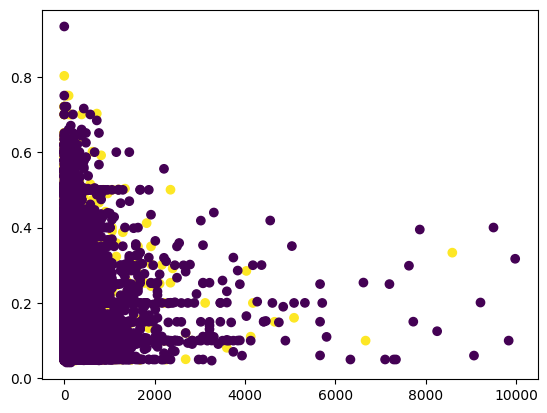

In [630]:
# Plot 'offset' vs 'category_id' . Dot color depends on 'conversion'
plt.scatter(sub_data["offset"], sub_data["discount"], c=sub_data["conversion"])

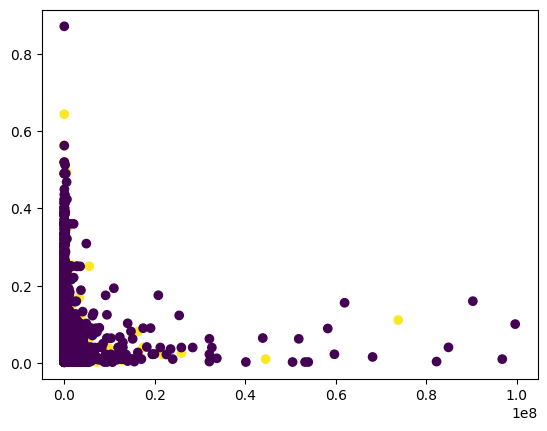

In [631]:
plt.scatter(sub_data["offset2"], sub_data["discount2"], c=sub_data["conversion"])

Text(0, 0.5, 'original_price')

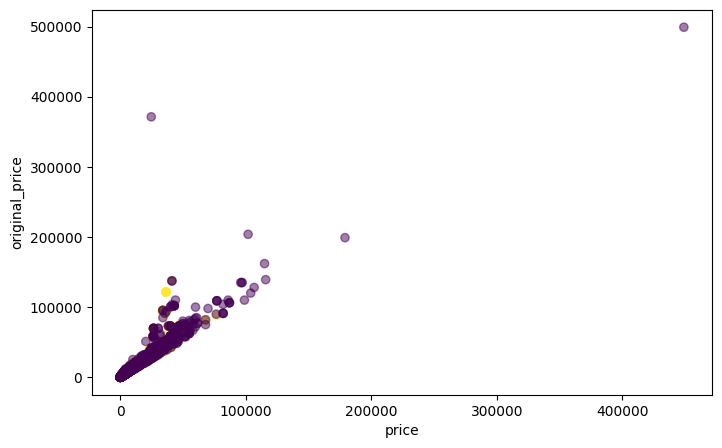

In [632]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(sub_data["price"], sub_data["original_price"], c=sub_data["conversion"], alpha=0.5)

ax.set_xlabel("price")
ax.set_ylabel("original_price")

Text(0, 0.5, 'offset')

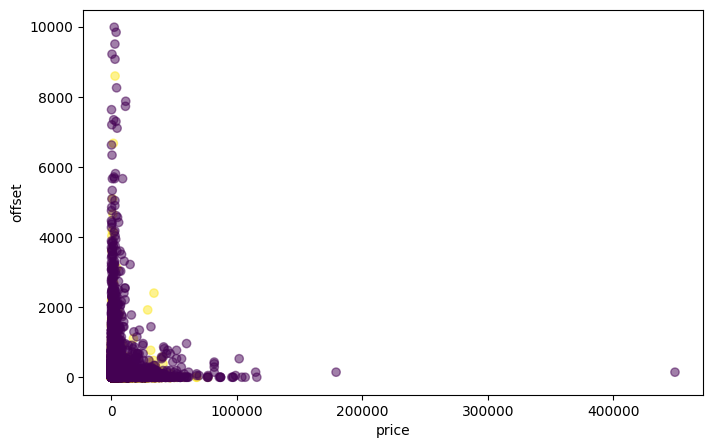

In [633]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(sub_data["price"], sub_data["offset"], c=sub_data["conversion"], alpha=0.5)

ax.set_xlabel("price")
ax.set_ylabel("offset")

Text(0, 0.5, 'offset2')

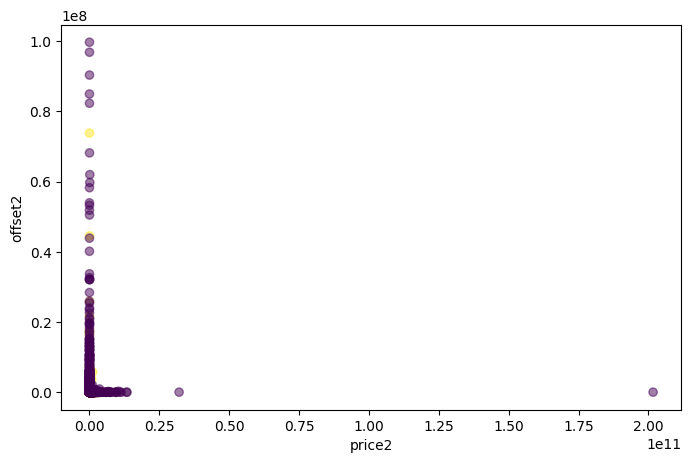

In [634]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(sub_data["price2"], sub_data["offset2"], c=sub_data["conversion"], alpha=0.5)

ax.set_xlabel("price2")
ax.set_ylabel("offset2")

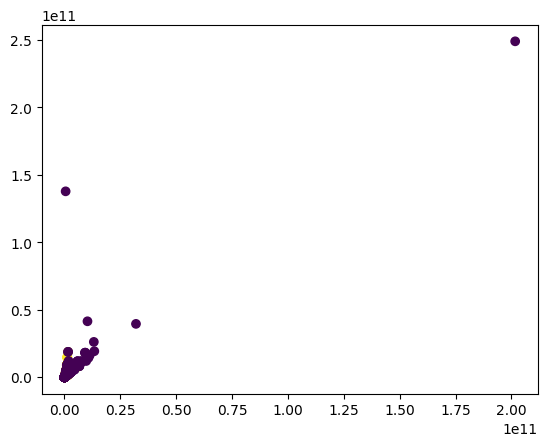

In [635]:
plt.scatter(sub_data["price2"], sub_data["original_price2"], c=sub_data["conversion"])

Text(0.5, 0, 'is_pdp')

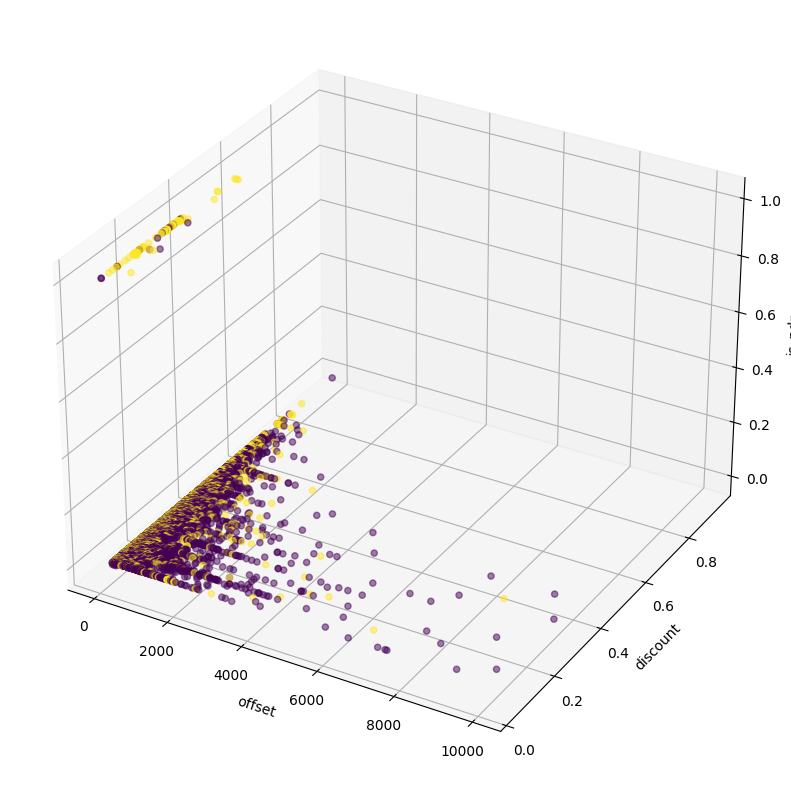

In [636]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    sub_data["offset"],
    sub_data["discount"],
    sub_data["is_pdp"],
    c=sub_data["conversion"],
    # cmap="coolwarm",
    alpha=.5
)

ax.set_xlabel("offset")
ax.set_ylabel("discount")
ax.set_zlabel("is_pdp")


Text(0.5, 0, 'price_diff')

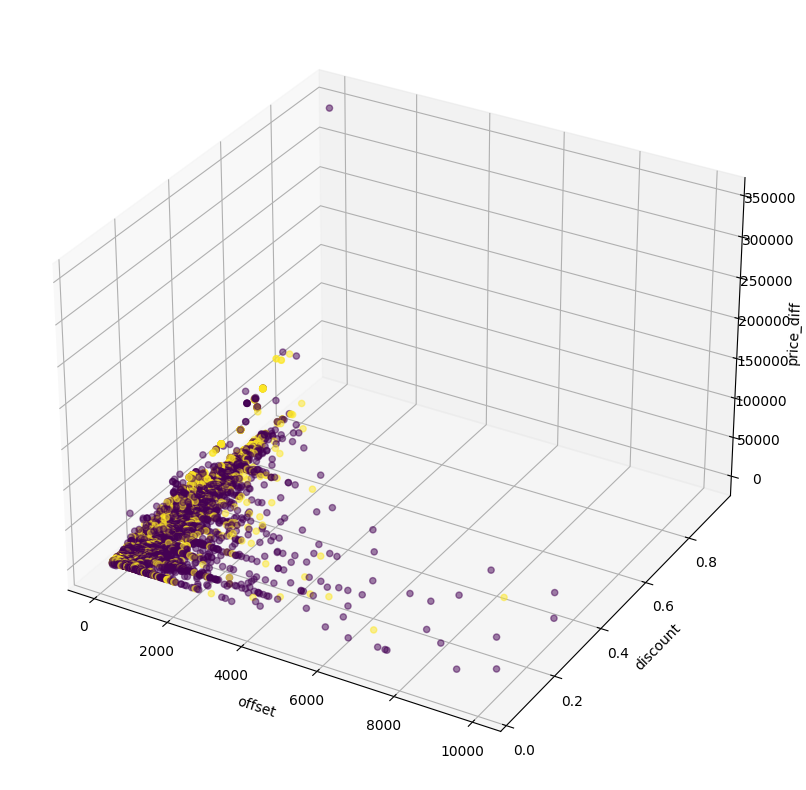

In [637]:
# Plot 'offset', 'discount', 'category_id' in 3D. Dot color depends on 'conversion'

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    sub_data["offset"],
    sub_data["discount"],
    sub_data["price_diff"],
    c=sub_data["conversion"],
    # cmap="coolwarm",
    alpha=.5
)

ax.set_xlabel("offset")
ax.set_ylabel("discount")
ax.set_zlabel("price_diff")


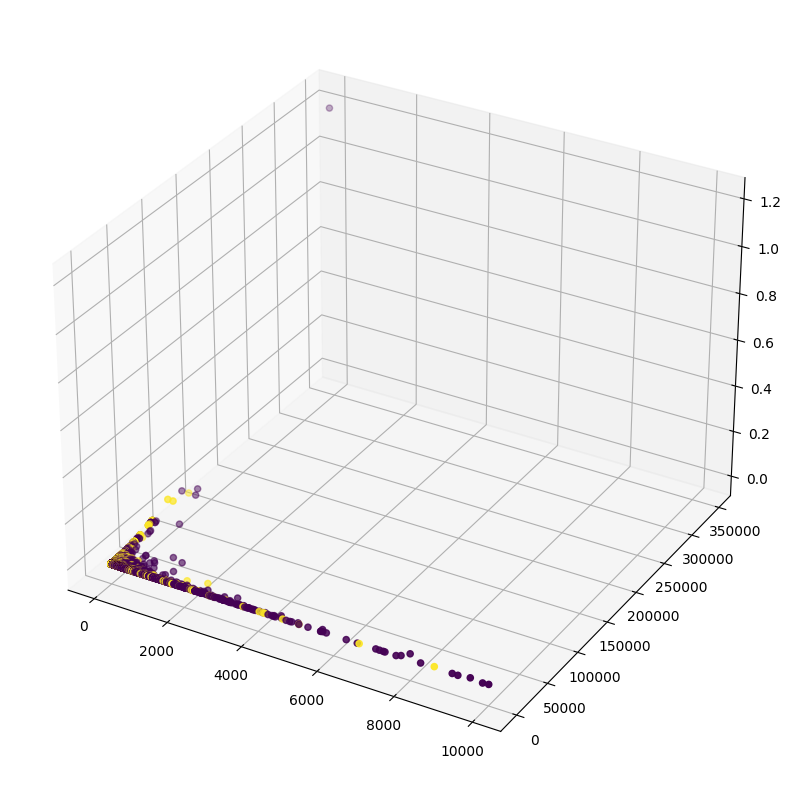

In [638]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# ax = fig.add_subplot(111)
ax.scatter(
    sub_data["offset"],
    sub_data["price_diff"],
    sub_data["offset"] ** 2 + sub_data["price_diff"]**2,
    c=sub_data["conversion"],
)

plt.show()

In [639]:
# # Plot hist boosted
# plot_data = comp_data.groupby("is_pdp")["conversion"].sum()
# plot_data


In [640]:
# Plot hour vs conversion
#comp_data.groupby("dayofweek")["conversion"].mean().plot()

## Word2Vec

In [18]:
# Word2Vec with NLTk
RETRAIN_W2C = False

comp_data["tokenized_title"] = comp_data["title"].apply(sent_tokenize)
comp_data["tokenized_title"] = comp_data["tokenized_title"].apply(lambda x: [word_tokenize(y) for y in x])
comp_data["tokenized_title"] = comp_data["tokenized_title"].apply(lambda x: [[y2 for y2 in y1 if re.compile("[A-Za-z]").search(y2[0])] for y1 in x])
comp_data["tokenized_title"] = comp_data["tokenized_title"].apply(lambda x: [[y2.lower() for y2 in y1] for y1 in x])
        

if RETRAIN_W2C:
        
    stop_words = set(stopwords.words('spanish'))

    w2v_model = Word2Vec(vector_size=300,
                                    window=3,
                                    min_count=5,
                                    negative=15,
                                    sample=0.01,
                                    workers=8,
                                    sg=1)
                                                                        
    w2v_model.build_vocab([e2 for e1 in comp_data["tokenized_title"].values for e2 in e1],
                    progress_per=10000)

    w2v_model.train([e2 for e1 in comp_data["tokenized_title"].values for e2 in e1],
                total_examples=w2v_model.corpus_count,
                epochs=30, report_delay=1)

    w2v_model.save("title_w2c.model")

else:
    w2v_model = Word2Vec.load("title_w2c.model")

In [19]:
# Obtención de embeddings de títulos utilizando el modelo Word2Vec
comp_data["title_embs"] = comp_data["tokenized_title"].apply(lambda x: np.mean(
    [   
        np.zeros(w2v_model.wv.vector_size) if e2 not in w2v_model.wv 
        else w2v_model.wv.get_vector(e2) if len(e2) > 0 
        else np.zeros(w2v_model.wv.vector_size) 
        for e1 in x for e2 in e1
    ],
    axis=0)
)

In [20]:
np.array(comp_data["title_embs"].tolist()).shape

(199972, 300)

In [21]:
comp_data["tokenized_title"] = comp_data["tokenized_title"].apply(lambda x: x[0])

In [22]:
comp_data["tokenized_title"]

0         [motorola, one, action, gb, denim, blue, gb, ram]
1                  [zapatillas, hovr, sonic, under, armour]
2         [pantalon, mujer, vestir, elastizado, tiro, al...
3         [trencity, pista, n°3, kit, turbo, elevación, ...
4              [memoria, ram, ddr2, samsung, intel, y, amd]
                                ...                        
199967    [frasco, dispenser, vidrio, c/relieve, c/sopor...
199968    [electro, estimulador, abdominal, reductor, fi...
199969    [auricular, bluetooth, vincha, micro, sd, radi...
199970               [transformers, generations, dreadwind]
199971    [pack, x, boxer, de, niño, sin, costura, dufou...
Name: tokenized_title, Length: 199972, dtype: object

In [23]:
comp_data[["embeddings_" + str(i) for i in range(w2v_model.wv.vector_size)]] = np.array(comp_data["title_embs"].tolist())

/Users/nacho/opt/anaconda3/envs/coding/lib/python3.8/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


In [24]:
comp_data[["embeddings_" + str(i) for i in range(w2v_model.wv.vector_size)]]

,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,...,embeddings_290,embeddings_291,embeddings_292,embeddings_293,embeddings_294,embeddings_295,embeddings_296,embeddings_297,embeddings_298,embeddings_299
0,0.407256,0.346109,0.034703,0.195872,0.105712,-0.096924,-0.086645,0.763543,-0.264425,-0.250102,...,0.048355,0.202031,0.284862,0.279447,-0.106692,0.484675,-0.141178,0.164191,-0.153946,0.044015
1,0.042679,0.285040,-0.085519,0.054269,-0.436977,0.009165,-0.043031,0.918024,0.396576,-0.262409,...,-0.329382,0.585860,-0.075787,0.415753,0.589815,0.373095,0.112062,-0.196132,0.075105,-0.205592
2,-0.140189,0.221102,0.334784,0.663381,-0.193465,0.098738,0.163559,0.354226,0.279351,0.449124,...,-0.069502,-0.015078,0.180559,0.182157,0.445096,0.668092,0.144087,-0.223072,0.156411,0.269213
3,0.270412,0.124530,-0.116732,-0.203255,-0.323604,-0.048130,-0.159898,0.539274,0.206988,-0.055276,...,-0.274872,0.565224,0.358737,0.405583,0.602786,0.236667,0.317710,-0.108944,0.071862,-0.418499
4,0.177160,0.292062,-0.015661,0.067940,-0.138912,-0.243836,-0.062292,0.367834,-0.398819,-0.350346,...,-0.174848,0.222140,0.151210,0.078478,0.247092,0.196130,-0.105131,-0.139780,0.086428,-0.121699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199967,-0.060557,0.086833,-0.055899,0.432190,-0.289145,-0.332855,0.415789,0.651786,-0.046805,-0.163709,...,-0.339807,0.105469,0.433681,0.120821,0.088977,0.233058,0.041193,-0.284257,0.019409,-0.319288
199968,-0.022782,-0.132960,-0.091529,0.444677,-0.515899,-0.142040,0.105987,0.580728,-0.488041,0.226574,...,-0.239526,0.395446,0.367903,0.003991,0.608837,0.322964,-0.000260,-0.403646,0.192786,-0.169928
199969,-0.120085,0.523469,0.212257,0.103961,-0.145219,-0.450245,0.103901,0.687452,-0.217462,-0.370850,...,-0.104306,0.210506,0.166247,0.054639,0.178691,0.089791,0.084518,-0.169389,-0.356164,-0.158580
199970,-0.079217,0.150441,0.177942,-0.019753,-0.168739,0.015797,-0.058106,0.147978,0.160441,0.052064,...,0.177821,0.189710,0.576359,0.444357,-0.023808,0.005769,0.015664,-0.245347,0.143789,-0.290579


In [39]:
comp_data.to_csv("data/competition_data_preprocessed_submit.csv", index=False)

/Users/nacho/opt/anaconda3/envs/coding/lib/python3.8/site-packages/pandas/core/internals/blocks.py:2074: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [41]:
import pacmap
# Reduce dimensionality of embeddings

dims = 100

pacmap_model = pacmap.PaCMAP(
    n_components = dims,
    verbose = True,
)
embs = pacmap_model.fit_transform(comp_data[["embeddings_" + str(i) for i in range(w2v_model.wv.vector_size)]].values)

comp_data[["pacmap_" + str(i) for i in range(dims)]] = embs

comp_data = comp_data.drop(columns=["embeddings_" + str(i) for i in range(w2v_model.wv.vector_size)])
comp_data = comp_data.drop(columns=["title_embs", "tokenized_title"])

Applied PCA, the dimensionality becomes 100
PaCMAP(n_neighbors=10, n_MN=5, n_FP=20, distance=euclidean, lr=1.0, n_iters=450, apply_pca=True, opt_method='adam', verbose=True, intermediate=False, seed=None)
Finding pairs
Found nearest neighbor
Calculated sigma
Found scaled dist
Pairs sampled successfully.
((1999720, 2), (999860, 2), (3999440, 2))
Initial Loss: 2471076.0
Iteration:   10, Loss: 7155445.000000
Iteration:   20, Loss: 2079337.625000
Iteration:   30, Loss: 1824217.000000
Iteration:   40, Loss: 1441681.875000
Iteration:   50, Loss: 1249319.375000
Iteration:   60, Loss: 1128724.625000
Iteration:   70, Loss: 1026516.125000
Iteration:   80, Loss: 919396.875000
Iteration:   90, Loss: 785398.125000
Iteration:  100, Loss: 563503.937500
Iteration:  110, Loss: 1036374.562500
Iteration:  120, Loss: 856865.750000
Iteration:  130, Loss: 760770.312500
Iteration:  140, Loss: 719495.250000
Iteration:  150, Loss: 700354.187500
Iteration:  160, Loss: 695137.125000
Iteration:  170, Loss: 694877

/Users/nacho/opt/anaconda3/envs/coding/lib/python3.8/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


In [648]:
# tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',ngram_range=(1,1), sublinear_tf=True)

# if tfidf_title:
#     tfidf_title = pd.DataFrame(tfidf.fit_transform(comp_data["title"]).toarray(), columns=tfidf.get_feature_names_out())
#     comp_data = pd.concat([comp_data, tfidf_title], axis=1)
#     comp_data = comp_data.drop("title", axis=1)

In [63]:
comp_data = pd.read_csv("data/competition_data_preprocessed_submit.csv")

## Splits

### Split Comp Data -> Full | Eval

In [64]:
full_data = comp_data[comp_data["ROW_ID"].isna()]
eval_data = comp_data[comp_data["ROW_ID"].notna()]
# del comp_data
gc.collect()

635

In [650]:
# df = pd.read_csv("data/competition_data.csv")
# print(df.isna().sum()[df.isna().sum() > 0])
# del df
# gc.collect()

In [43]:
# Count nan values per column

full_data.isna().sum()[full_data.isna().sum() > 0]

benefit         1
ROW_ID     180761
dtype: int64

In [652]:
# The following cols have nan values
# avg_gmv_item_sel
# qty_items_dom
# qty_items_sel
# domain_dominance depends on qty_items_dom

# For those columns, are the rows with nan values the same?

# full_data[full_data["avg_gmv_item_sel"].isna()]["qty_items_dom"].isna().sum(), full_data[full_data["avg_gmv_item_sel"].isna()]["qty_items_sel"].isna().sum(), full_data[full_data["avg_gmv_item_sel"].isna()]["domain_dominance"].isna().sum()

# Yes, they are the same rows

In [653]:
# Drop those rows

# full_data = full_data.dropna(subset=["avg_gmv_item_sel"])

In [44]:
# Count nan values per column

full_data.isna().sum()[full_data.isna().sum() > 0]

benefit         1
ROW_ID     180761
dtype: int64

### Train Test Split

In [65]:
# Shuffle
full_data = full_data.sample(frac=1, random_state=19092140).reset_index(drop=True)

train_data, test_data = train_test_split(full_data, test_size=0.2, train_size=0.8, random_state=42)

In [656]:
# train_vect = tfidf.fit_transform(train_data["title"])

In [657]:
# if tfidf_title:
#     train_df = pd.DataFrame(train_vect.toarray())
#     train_data[tfidf.get_feature_names_out()] = train_df

#     test_vect = tfidf.transform(test_data["title"])
#     test_df = pd.DataFrame(test_vect.toarray())
#     test_data[tfidf.get_feature_names_out()] = test_df

#     eval_vect = tfidf.transform(eval_data["title"])
#     eval_df = pd.DataFrame(eval_vect.toarray())
#     eval_data[tfidf.get_feature_names_out()] = eval_df

### Balancing

In [658]:
count_converts_test = test_data[test_data["conversion"] == True].shape[0]
count_not_converts_test = test_data[test_data["conversion"] == False].shape[0]
ratio = count_converts_test / count_not_converts_test

# From test_data, keep ratio of count_not_converts_test entries

not_converts = test_data[test_data["conversion"] == False].sample(frac=ratio)

new_test_data = pd.concat([test_data[test_data["conversion"] == True], not_converts])
new_test_data["conversion"].value_counts()

1.0    4189
0.0    4189
Name: conversion, dtype: int64

In [659]:
# Balance Train Data by conversion

len(train_data[train_data["conversion"] == False])

123015

In [66]:
# if NaN in conversion, drop those rows
train_data = train_data.dropna(subset=["conversion"])
test_data = test_data.dropna(subset=["conversion"])

In [47]:
if balance_train:

    count_converts_train = len(train_data[train_data["conversion"] == True])
    count_not_converts_train = len(train_data[train_data["conversion"] == False])

    ratio = count_converts_train / count_not_converts_train

    # From train_data, keep ratio of count_not_converts_train entries

    not_converts = train_data[train_data["conversion"] == False].sample(frac=ratio)

    new_train_data = pd.concat([train_data[train_data["conversion"] == True], not_converts])

    train_data = new_train_data

In [662]:
train_data

,available_quantity,avg_gmv_item_sel,benefit,conversion,domain_id,free_shipping,fulfillment,health,is_pdp,product_id,...,embeddings_290,embeddings_291,embeddings_292,embeddings_293,embeddings_294,embeddings_295,embeddings_296,embeddings_297,embeddings_298,embeddings_299
118476,47,40.225781,0.001,0.0,55,0,0,0.88,0,4440,...,-0.178406,0.166283,0.283246,-0.098507,0.267567,0.044455,0.072173,-0.111509,-0.032108,-0.120394
155078,41,183.271212,0.001,0.0,1603,0,0,0.75,0,4440,...,-0.138816,0.334263,0.296448,-0.270642,0.422005,0.532259,0.229036,-0.203922,-0.046556,-0.029637
90038,18,111.338322,0.001,0.0,359,0,0,0.70,0,4440,...,-0.429352,0.565748,0.344101,0.164614,0.563233,0.395738,0.419508,-0.076731,0.182954,-0.289266
66671,24,19.147965,0.001,0.0,590,0,0,0.87,0,4440,...,0.233810,0.206071,0.410012,-0.035723,0.461131,0.007318,0.021708,0.195896,-0.034188,-0.036917
19204,15,194.121895,0.001,0.0,1683,0,1,0.77,0,4440,...,-0.018227,0.357568,0.307265,0.134692,0.264261,0.100441,-0.117328,0.028557,0.162190,0.018319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,916,135.827570,0.001,0.0,1317,0,0,0.88,0,4440,...,0.284023,0.124998,0.370357,-0.282858,0.786176,0.039469,-0.062685,0.255842,-0.000186,-0.256737
103694,103,117.069687,0.001,0.0,1263,1,0,1.00,0,4440,...,0.094128,0.243875,0.372613,0.032297,0.606971,0.442249,0.194203,0.140918,0.028828,-0.494151
131932,24,136.340116,0.001,0.0,1003,0,0,0.77,0,4440,...,-0.059337,0.251809,0.215710,-0.040740,0.668934,0.267611,0.109584,0.106687,0.190414,-0.100336
146867,12,161.031216,0.001,0.0,1366,0,0,0.72,0,4440,...,0.038649,0.311812,0.480986,0.202540,0.597268,0.430453,0.316085,-0.021162,0.025453,-0.251254


In [663]:
# ! Oversample, repeats into Validation
# train_data = train_data.append(train_data[train_data["conversion"] == True].sample(frac=1, replace=True))
# train_data = train_data.append(train_data[train_data["conversion"] == True].sample(frac=1, replace=True))
# train_data["conversion"].value_counts()

###  Split X | y

In [67]:
y_train = train_data["conversion"]
X_train = train_data.drop(columns=["conversion", "ROW_ID"])
X_train = X_train.select_dtypes(include='number')

y_test = test_data["conversion"]
X_test = test_data.drop(columns=["conversion", "ROW_ID"])
X_test = X_test.select_dtypes(include='number')

del train_data
del test_data

gc.collect()

0

### Validation Split

In [68]:
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.25, train_size=0.75, random_state=42)

## Submission File

In [50]:
def create_submission_file(model, feature_cols=[], filename="submission.csv"):
    global comp_data
    global eval_data
    
    if len(feature_cols) == 0:
        feature_cols = model.get_booster().feature_names

    #feature_cols = xgb4_model.get_booster().feature_names
    #model = final_classifier

    eval_data = comp_data[comp_data["ROW_ID"].notna()]
    # del comp_data

    # Predict on the evaluation set
    eval_data = eval_data.drop(columns=["conversion"])
    eval_data = eval_data.select_dtypes(include='number')
    y_preds = model.predict_proba(eval_data[feature_cols])[:, model.classes_ == 1].squeeze()

    # Make the submission file
    submission_df = pd.DataFrame({"ROW_ID": eval_data["ROW_ID"], "conversion": y_preds})
    submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
    submission_df.to_csv(filename, index=False)

## Models

### XGBoost

In [31]:
random_state = 12345

In [675]:
full_data = comp_data[comp_data["ROW_ID"].isna()]
train_data, test_data = train_test_split(full_data, test_size=0.25, train_size=0.75, random_state=42)

y_train = train_data["conversion"]
X_train = train_data.drop(columns=["conversion", "ROW_ID"])
X_train_tokenized_title = X_train["tokenized_title"]
X_train = X_train.select_dtypes(include='number')
X_train["tokenized_title"] = X_train_tokenized_title

y_test = test_data["conversion"]
X_test = test_data.drop(columns=["conversion", "ROW_ID"])
X_test_tokenized_title = X_test["tokenized_title"]
X_test = X_test.select_dtypes(include='number')
X_test["tokenized_title"] = X_test_tokenized_title

del train_data
del test_data
del full_data
gc.collect()

tfidf = TfidfVectorizer(tokenizer=lambda x: x, token_pattern=None, lowercase=False, min_df=5, sublinear_tf=True)

xgb_tfidf_w2v = make_pipeline(
    SimpleImputer(strategy="median"),
    xgb.XGBClassifier(
        n_jobs=-1,
        seed = random_state,
    )
)

X_train_tfidf = tfidf.fit_transform(X_train["tokenized_title"])
X_test_tfidf = tfidf.transform(X_test["tokenized_title"])

# X_train_w2v = np.array(X_train["title_embs"].tolist())
# X_test_w2v = np.array(X_test["title_embs"].tolist())

xgb_tfidf_w2v.fit(X_train_tfidf, y_train)

roc_auc_score(y_test, xgb_tfidf_w2v.predict_proba(X_test_tfidf)[:, xgb_tfidf_w2v.classes_ == 1])

0.7410456693924521

In [ ]:
xgb_tfidf_w2v_full_model = xgb.XGBClassifier(
        objective = 'binary:logistic',
        seed = random_state,
        n_jobs=-1,
        verbosity=1,
)

tfidf_w2v_full_train = X_train.copy()
tfidf_w2v_full_test = X_test.copy()

tfidf_w2v_full_train[["w2v_tfidf_" + str(i) for i in range(X_train_tfidf.shape[1])]] = pd.DataFrame(X_train_tfidf.toarray())
tfidf_w2v_full_test[["w2v_tfidf_" + str(i) for i in range(X_test_tfidf.shape[1])]] = pd.DataFrame(X_test_tfidf.toarray())

tfidf_w2v_full_train = tfidf_w2v_full_train.drop(columns=["tokenized_title"])
tfidf_w2v_full_test = tfidf_w2v_full_test.drop(columns=["tokenized_title"])

tfidf_w2v_full_train = tfidf_w2v_full_train.copy()
tfidf_w2v_full_test = tfidf_w2v_full_test.copy()

xgb_tfidf_w2v_full_model.fit(tfidf_w2v_full_train, y_train)

score = roc_auc_score(y_test, xgb_tfidf_w2v_full_model.predict_proba(tfidf_w2v_full_test)[:, xgb_tfidf_w2v_full_model.classes_ == 1])

notify("XGB_TFIDF_W2V", "Done. Score: {}".format(score))

create_submission_file(xgb_tfidf_w2v_full_model,
                       xgb_tfidf_w2v_full_model.get_booster().feature_names,
                       "outputs/xgb_tfidf_w2v_full: {:.5f} {}.csv".format(score, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
)

score

### Train XGBoost Model (Default params) with Cross Validation

In [90]:
xgb1_model = xgb.XGBClassifier(
    objective = 'binary:logistic',
    seed = random_state,
    eval_metric = 'auc',
    n_jobs=-1,
    #base_score=0.74
)

xgb1_model.fit(X_train_sub, y_train_sub, eval_set=[(X_val, y_val)], verbose=20)

notify("XGB1", "Done")

[0]	validation_0-auc:0.86066
[20]	validation_0-auc:0.88422
[40]	validation_0-auc:0.88910
[60]	validation_0-auc:0.89090
[80]	validation_0-auc:0.89192
[99]	validation_0-auc:0.89244


#### ROC AUC

In [97]:
xgb_cv_score = roc_auc_score(y_test, xgb1_model.predict_proba(X_test)[:, xgb1_model.classes_ == 1])
xgb_cv_score 

0.8936728115116593

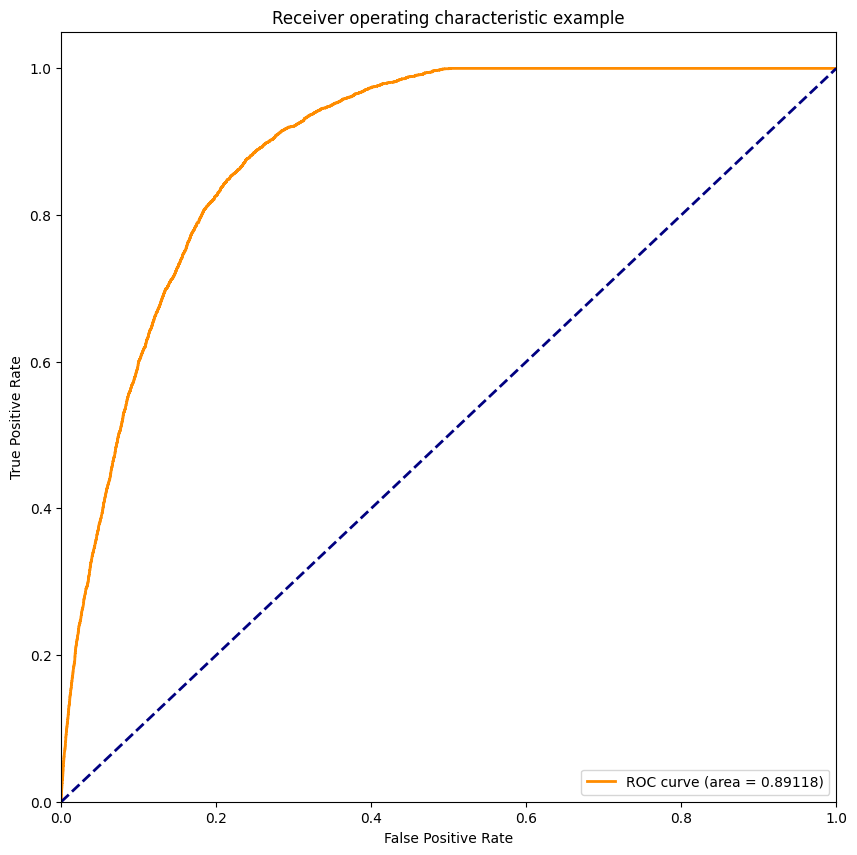

In [ ]:
# Plot ROC curve

fpr, tpr, thresholds = roc_curve(y_test, xgb1_model.predict_proba(X_test)[:, xgb1_model.classes_ == 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.5f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])

plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.title('Receiver operating characteristic example')

plt.legend(loc="lower right")

plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Gain', ylabel='Features'>

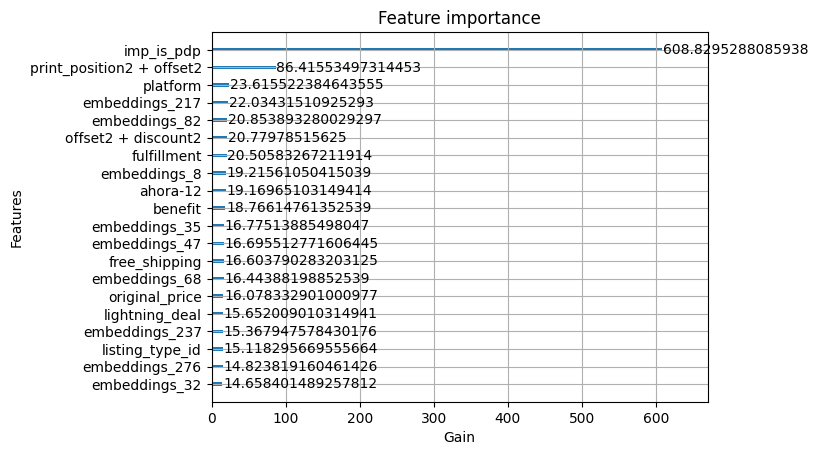

In [ ]:
# Feature Importance
xgb.plot_importance(xgb1_model, max_num_features=20, importance_type="gain", xlabel="Gain")

<Axes: title={'center': 'Feature importance'}, xlabel='Cover', ylabel='Features'>

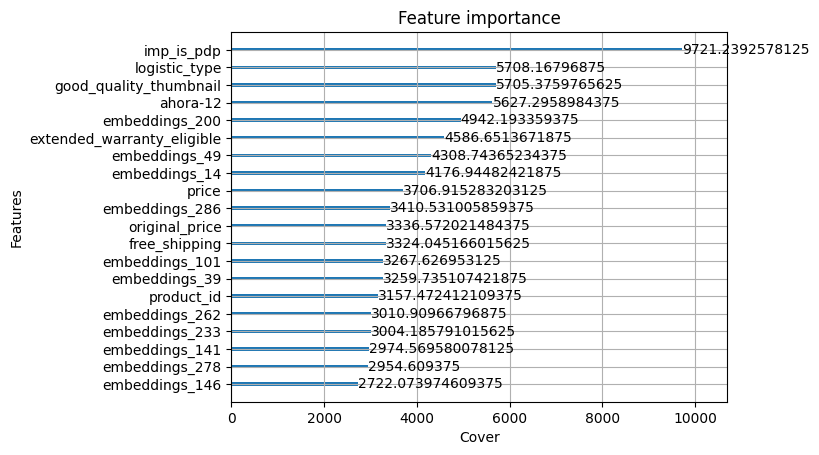

In [ ]:
# Feature Importance
xgb.plot_importance(xgb1_model, max_num_features=20, importance_type="cover", xlabel="Cover")

#### Feature Importance

In [ ]:
# # Get Feature Importance from the classifier xgb1_model
feature_importances = pd.DataFrame(
    xgb1_model.feature_importances_,
    index = X_train.columns,
    columns=['importance']).sort_values('importance', ascending=False)

feature_importances.head(20)

,importance
imp_is_pdp,0.170219
print_position2 + offset2,0.024160
platform,0.006603
embeddings_217,0.006160
embeddings_82,0.005830
offset2 + discount2,0.005810
fulfillment,0.005733
embeddings_8,0.005372
ahora-12,0.005360
benefit,0.005247


In [ ]:
# # Add gain column
gains = sorted(xgb1_model.get_booster().get_score(importance_type="gain").items(), key=lambda x: x[1], reverse=True)

gains_pd = pd.DataFrame(gains, columns=["feature", "gain"]).set_index("feature").sort_values("gain", ascending=False)

gains_pd.head(20)

,gain
feature,
imp_is_pdp,608.829529
print_position2 + offset2,86.415535
platform,23.615522
embeddings_217,22.034315
embeddings_82,20.853893
offset2 + discount2,20.779785
fulfillment,20.505833
embeddings_8,19.215611
ahora-12,19.169651


In [ ]:
feature_importances.head(20)

,importance
imp_is_pdp,0.170219
print_position2 + offset2,0.024160
platform,0.006603
embeddings_217,0.006160
embeddings_82,0.005830
offset2 + discount2,0.005810
fulfillment,0.005733
embeddings_8,0.005372
ahora-12,0.005360
benefit,0.005247


In [ ]:
xgb_emb_model = xgb.XGBClassifier(
    objective = 'binary:logistic',
    seed = random_state,
    eval_metric = 'auc',
    n_jobs=-1,
)

emb_train_cols = ["embeddings_" + str(i) for i in range(w2v_model.wv.vector_size)]

xgb_emb_model.fit(X_train_sub[emb_train_cols], y_train_sub, eval_set=[(X_val[emb_train_cols], y_val)], verbose=20)

notify("XGB_EMB", "Done")

roc_auc_score(y_test, xgb_emb_model.predict_proba(X_test[emb_train_cols])[:, xgb_emb_model.classes_ == 1])

# Embedding Component Importance 
# Get Feature Importance from the classifier xgb_emb_model

feature_importances_emb = pd.DataFrame(
    xgb_emb_model.feature_importances_,
    index = X_train_sub[emb_train_cols].columns,
    columns=['importance']).sort_values('importance', ascending=False)

feature_importances_emb.head(20)

[0]	validation_0-auc:0.64019
[20]	validation_0-auc:0.74116
[40]	validation_0-auc:0.74620
[60]	validation_0-auc:0.74872
[80]	validation_0-auc:0.75016
[99]	validation_0-auc:0.75028


,importance
embeddings_258,0.017875
embeddings_38,0.011798
embeddings_147,0.009613
embeddings_20,0.009271
embeddings_97,0.008734
embeddings_63,0.008565
embeddings_70,0.008415
embeddings_145,0.008392
embeddings_122,0.008137
embeddings_239,0.008096


Text(0.5, 0, 'embeddings_38')

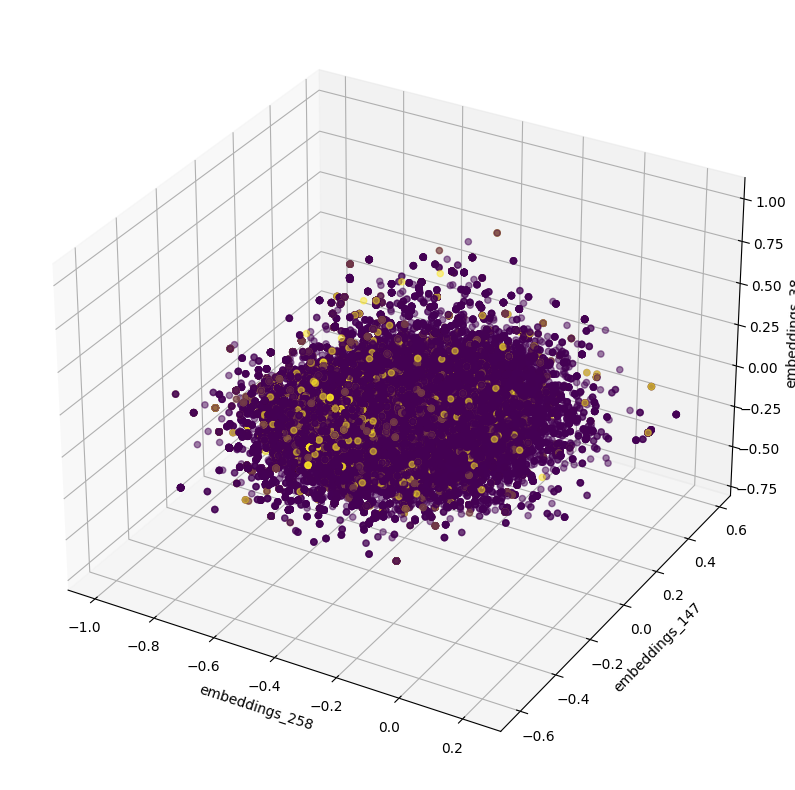

In [ ]:
# Plot Embeddings 217, 82, 8 in 3d

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    X_train["embeddings_258"],
    X_train["embeddings_147"],
    X_train["embeddings_38"],
    c=y_train,
    # cmap="coolwarm",
    alpha=.5
)

ax.set_xlabel("embeddings_258")
ax.set_ylabel("embeddings_147")
ax.set_zlabel("embeddings_38")

In [ ]:
import pacmap

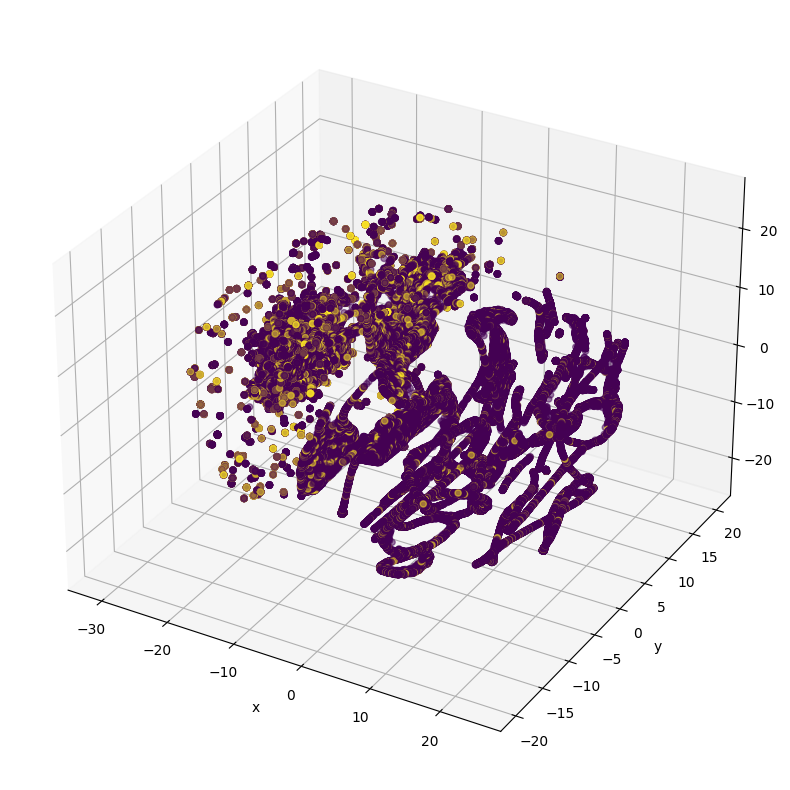

In [ ]:
top_attrs = feature_importances.head(100).index

for attr in top_attrs:
    # if X_train[attr] has more than 0/1 values
    if len(X_train[attr].value_counts()) <= 2:
        top_attrs = top_attrs.drop(attr)


embs = pacmap.PaCMAP(
        n_components = 3,
        n_neighbors = 10,
        MN_ratio=0.5,
        FP_ratio=2.0,
    ).fit_transform(
        SimpleImputer(strategy="median").fit_transform(
                X_train[top_attrs].values
            )
        )

# plt.figure(figsize = (10, 5))
# plt.scatter(embs[:, 0],
#             embs[:, 1],
#             s = 30,
#             c = y_train,
#             alpha = 0.5)
# plt.show()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    embs[:, 0],
    embs[:, 1],
    embs[:, 2],
    c=y_train,
    # cmap="coolwarm",
    alpha=.5
)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

plt.show()

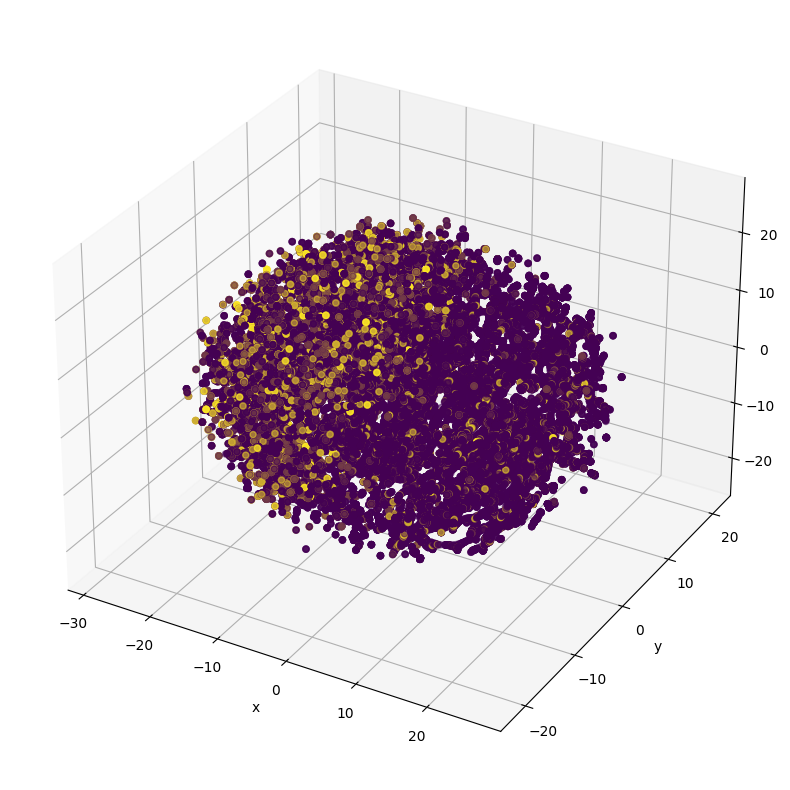

In [ ]:
# plt.figure(figsize = (10, 5))
# plt.scatter(embs[:, 0],
#             embs[:, 1],
#             s = 30,
#             c = y_train,
#             alpha = 0.5)
# plt.show()

# 3D plot

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    embs[:, 0],
    embs[:, 1],
    embs[:, 2],
    c=y_train,
    # cmap="coolwarm",
    alpha=.5
)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

plt.show()

### Train XGBoost Model (Top 20 Gain params) with Cross Validation

In [ ]:
# xgb2_model = xgb.XGBClassifier(
#     objective = 'binary:logistic',
#     seed = random_state,
#     n_jobs=-1,
# )

# reduced_cols = gains_pd.head(20).index

# xgb2_model.fit(X_train, y_train)

In [ ]:
# roc_auc_score(y_test, xgb2_model.predict_proba(X_test)[:, xgb2_model.classes_ == 1])

In [ ]:
# covers = sorted(xgb1_model.get_booster().get_score(importance_type="cover").items(), key=lambda x: x[1], reverse=True)
# covers_pd = pd.DataFrame(covers, columns=["feature", "cover"]).set_index("feature").sort_values("cover", ascending=False)


# xgb_model_covers = xgb.XGBClassifier(
#     objective = 'binary:logistic',
#     seed = random_state,
#     n_jobs=-1,
# )

# reduced_cols = covers_pd.head(20).index

# xgb_model_covers.fit(X_train[reduced_cols], y_train)

# roc_auc_score(y_test, xgb_model_covers.predict_proba(X_test[reduced_cols])[:, xgb_model_covers.classes_ == 1])

#### ROC AUC

In [ ]:
# roc_auc_score(y_test, xgb2_model.predict_proba(X_test)[:, xgb2_model.classes_ == 1])

#### Feature Importance

In [ ]:
# Feature Importance
# xgb.plot_importance(xgb2_model, max_num_features=20, importance_type="gain", xlabel="Gain")

In [ ]:
# # Feature Importance
# fig, ax = plt.subplots(figsize=(5, 20))

# xgb.plot_importance(xgb2_model, max_num_features=100, importance_type="gain", xlabel="Gain", ax=ax)

## Retrain Model with Validation Data

In [ ]:
# del comp_data
# del full_data
# gc.collect()

In [89]:
# params = {'colsample_bytree': 0.9958188825321641, 'gamma': 0.9488078042954764, 'learning_rate': 0.07108927605766976, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 4, 'subsample': 0.8232243201689888}
xgb4_model = xgb.XGBClassifier(
        # **params,
        objective = 'binary:logistic',
        seed = random_state,
        n_jobs=-1,
        verbosity=1,
)

xgb4_model.fit(X_train, y_train)

xgb_ho_score = roc_auc_score(y_test, xgb4_model.predict_proba(X_test)[:, xgb4_model.classes_ == 1])

notify("XGB4", "Done. Score: {}".format(xgb_ho_score))

create_submission_file(xgb4_model,
                       xgb4_model.get_booster().feature_names,
                       "outputs/xgb_polyfeat_w2v_smallohe: {:.5f} {}.csv".format(xgb_ho_score, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
)

xgb_ho_score

0.8981698903861902

#### ROC AUC on X_test

In [ ]:
# roc_auc_score(y_test, xgb4_model.predict_proba(X_test)[:, xgb4_model.classes_ == 1])

#### ROC AUC on Balanced X_test (Subsampled X_test for conversion == 0)

In [ ]:
new_X_test = new_test_data.drop(columns=["conversion", "ROW_ID"])
new_X_test = new_X_test.select_dtypes(include='number')

new_y_test = new_test_data["conversion"]

# roc_auc_score(new_y_test, xgb2_model.predict_proba(new_X_test)[:, xgb2_model.classes_ == 1])

#### Confusion Matrix

In [ ]:
# # Confusion Matrix for xgb2_model on new_test_data

# conf_mx = confusion_matrix(new_y_test, xgb2_model.predict(new_X_test))

# true_neg, false_pos, false_neg, true_pos = conf_mx.ravel()

# true_neg, false_pos, false_neg, true_pos

In [ ]:
""" xgb3_model = make_pipeline(
    SimpleImputer(strategy="median"),
    xgb.XGBClassifier(
        objective = 'binary:logistic',
        seed = random_state,
        n_jobs=-1,
    )
)

xgb3_model.fit(X_train, y_train)

roc_auc_score(y_test, xgb3_model.predict_proba(X_test)[:, xgb3_model.classes_ == 1]) """

' xgb3_model = make_pipeline(\n    SimpleImputer(strategy="median"),\n    xgb.XGBClassifier(\n        objective = \'binary:logistic\',\n        seed = random_state,\n        n_jobs=-1,\n    )\n)\n\nxgb3_model.fit(X_train, y_train)\n\nroc_auc_score(y_test, xgb3_model.predict_proba(X_test)[:, xgb3_model.classes_ == 1]) '

### Random Forest

In [94]:
rfc = make_pipeline(
    SimpleImputer(strategy="median"),
    RandomForestClassifier()r
)

rfc.fit(X_train, y_train)

roc_auc_score(y_test, rfc.predict_proba(X_test)[:, rfc.classes_ == 1])

0.8379120089274292

### Voting Classifier (XGBoost + Random Forest)

In [ ]:
voting_rfc_xgb = VotingClassifier(
    estimators=[
        ("rfc", rfc),
        ("xgb", xgb4_model)
    ],
    voting="soft",
    n_jobs=-1
)

# voting_rfc_xgb.fit(X_train, y_train)

# roc_auc_score(y_test, voting_rfc_xgb.predict_proba(X_test)[:, voting_rfc_xgb.classes_ == 1])

### GradientBoostingClassifier

In [ ]:
gbc = make_pipeline(
    SimpleImputer(strategy="median"),
    GradientBoostingClassifier(verbose=2)
)

# gbc.fit(X_train, y_train)

# score = roc_auc_score(y_test, gbc.predict_proba(X_test)[:, gbc.classes_ == 1])

# notify("GBC", "Done. Score: {}".format(score))

# score

### HistGradientBoostingClassifier

In [92]:
hgb = HistGradientBoostingClassifier(verbose=2)

hgb.fit(X_train, y_train)

hgb_score = roc_auc_score(y_test, hgb.predict_proba(X_test)[:, hgb.classes_ == 1])

notify("HGB", "Done. Score: {}".format(hgb_score))

hgb_score

Binning 0.407 GB of training data: 6.870 s
Binning 0.045 GB of validation data: 0.108 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.28997, val loss: 0.29107, in 0.125s
[2/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.27734, val loss: 0.27925, in 0.112s
[3/100] 1 tree, 31 leaves, max depth = 12, train loss: 0.26759, val loss: 0.27004, in 0.120s
[4/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.25987, val loss: 0.26272, in 0.097s
[5/100] 1 tree, 31 leaves, max depth = 12, train loss: 0.25343, val loss: 0.25688, in 0.140s
[6/100] 1 tree, 31 leaves, max depth = 12, train loss: 0.24804, val loss: 0.25180, in 0.097s
[7/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.24332, val loss: 0.24731, in 0.091s
[8/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.23920, val loss: 0.24343, in 0.085s
[9/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.23562, val loss: 0.24021, in 0.102s
[10/100] 1 tree, 31 leaves, max depth = 9, t

0.896437207409335

### AdaBoostClassifier

In [93]:
abc = make_pipeline(
    SimpleImputer(strategy="median"),
    AdaBoostClassifier()
)

abc.fit(X_train, y_train)

abc_score = roc_auc_score(y_test, abc.predict_proba(X_test)[:, abc.classes_ == 1])

notify("ABC", "Done. Score: {}".format(abc_score))

abc_score

0.8806026762023238

### ExtraTreesClassifier

In [ ]:
etc = make_pipeline(
    SimpleImputer(strategy="median"),
    ExtraTreesClassifier()
)

# etc.fit(X_train, y_train)

# score = roc_auc_score(y_test, etc.predict_proba(X_test)[:, etc.classes_ == 1])

# notify("ETC", "Done. Score: {}".format(score))

# score

### Voting Classifier Alt

In [ ]:
voting_alt = VotingClassifier(
    estimators=[
        # ("rfc", rfc),
        ("xgb", xgb4_model),
        ("hgb", hgb),
        ("abc", abc),
    ],
    voting="soft",
    n_jobs=-1,
)

# voting_alt.fit(X_train, y_train)

# score = roc_auc_score(y_test, voting_alt.predict_proba(X_test)[:, voting_alt.classes_ == 1])

# notify("Voting Alt", "Done. Score: {}".format(score))

# create_submission_file(voting_alt,
#                        xgb4_model.get_booster().feature_names, 
#                        "outputs/submission_voting(rfc, xgb, hgb, abc): {:.5f}.csv".format(score)
# )

# score

In [ ]:
voting_alt

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                             ('hgb', HistGradientBoostingClassifier(verbose=2)),
                             ('abc',
                              Pipeline(steps=[('simpleimputer',
                                               SimpleImputer(strategy='median')),
                                              ('adaboostclassifier',
                                               AdaBoostClassifier())]))],
                 n_jobs=-1, voting='soft')

### Average Classifier

In [ ]:
# average classifier
from sklearn.utils._pprint import _EstimatorPrettyPrinter

class AverageClassifier:
    def __init__(self, models):
        self.models = models
        self.classes_ = models[0].classes_

    def predict_proba(self, X):
        return np.mean([model.predict_proba(X) for model in self.models], axis=0)

    def predict(self, X):
        return np.mean([model.predict(X) for model in self.models], axis=0)

    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)

    def __repr__(self, N_CHAR_MAX=700):
        # N_CHAR_MAX is the (approximate) maximum number of non-blank
        # characters to render. We pass it as an optional parameter to ease
        # the tests.

        # Using _EstimatorPrettyPrinter

        pp = _EstimatorPrettyPrinter(
            compact=True,
            indent=1,
            indent_at_name=True,
            n_max_elements_to_show=N_MAX_ELEMENTS_TO_SHOW,
        )

        repr_ = pp.pformat(self)

        return repr_
        


# average_classifier = AverageClassifier(
#     [
#         #rfc,
#         xgb4_model,
#         hgb,
#         abc,
#         #voting_alt
#     ]
# )

# # average_classifier.fit(X_train, y_train)

# score = roc_auc_score(y_test, average_classifier.predict_proba(X_test)[:, average_classifier.classes_ == 1])

# notify("AVG", "Done. Score: {}".format(score))

# create_submission_file(average_classifier, 
#                        xgb4_model.get_booster().feature_names, 
#                        "outputs/submission_avg(xgb, hgb, abc): {:.5f}.csv".format(score)
# )

# score

### Stacking Classifier

In [ ]:
# Stacking Classifier

stacking_classifier = StackingClassifier(
    estimators=[
        #("rfc", rfc),
        ("xgb", xgb4_model),
        ("hgb", hgb),
        #("abc", abc),
    ],
    final_estimator=LogisticRegression(),
    n_jobs=-1,
    stack_method="predict_proba",
    verbose=2
)

stacking_classifier.fit(X_train, y_train)

score = roc_auc_score(y_test, stacking_classifier.predict_proba(X_test)[:, stacking_classifier.classes_ == 1])

notify("STACK", "Done. Score: {}".format(score))

create_submission_file(stacking_classifier,
                       xgb4_model.get_booster().feature_names, 
                       "outputs/submission_stack(xgb, hgb, abc)_polyfeat: {:.5f} {}.csv".format(score, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
)

score

Binning 0.361 GB of training data: 8.712 s
Binning 0.040 GB of validation data: 0.320 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.29013, val loss: 0.29071, in 0.197s
[2/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.27738, val loss: 0.27830, in 0.174s
[3/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.26766, val loss: 0.26888, in 0.180s
[4/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.25990, val loss: 0.26115, in 0.170s
[5/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.25352, val loss: 0.25498, in 0.173s
[6/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.24813, val loss: 0.24990, in 0.191s
[7/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.24335, val loss: 0.24561, in 0.163s
[8/100] 1 tree, 31 leaves, max depth = 14, train loss: 0.23914, val loss: 0.24181, in 0.166s
[9/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.23548, val loss: 0.23832, in 0.163s
[10/100] 1 tree, 31 leaves, max depth = 12, 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Binning 0.289 GB of training data: Binning 0.289 GB of training data: Binning 0.289 GB of training data: Binning 0.289 GB of training data: Binning 0.289 GB of training data: 16.437 s
Binning 0.032 GB of validation data: 16.776 s
Binning 0.032 GB of validation data: 16.552 s
Binning 0.032 GB of validation data: 17.188 s
Binning 0.032 GB of validation data: 17.423 s
Binning 0.032 GB of validation data: 1.132 s
0.833 s
Fitting gradient boosted rounds:
[1/100] Fitting gradient boosted rounds:
[1/100] 0.884 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.28985, val loss: 0.29115, in 0.572s
[2/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.29024, val loss: 0.29094, in 0.596s
[2/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.28997, val loss: 0.29130, in 0.526s
[2/100] 1.087 s
Fitting gradient boosted rounds:
[1/100] 1.173 s
1 tree, 31 leaves, max depth = 11, train loss: 0.27692, val loss: 0.27940, in 0.466s
[3/100] Fitting gradient bo

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   54.1s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   54.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   54.5s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  6.0min remaining:  9.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.1min finished


0.8980796621150097

In [ ]:
stacking_classifier

StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              gpu_id=None, grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=-1,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...)),
                               ('hgb',
                                HistGradientBoostingClassifier(verbose=2))],
                   final_estimator=LogisticRegression(), n_jobs=-1,
                   stack_method='predict_proba', verbose=2)

In [ ]:
# Stacking Classifier

# ideas for final_estimator
# - LogisticRegression
# - XGBClassifier
# - RandomForestClassifier
# - GradientBoostingClassifier


stacking_classifier_2 = StackingClassifier(
    estimators=[
        ("xgb", xgb4_model),
        ("hgb", hgb),
        ("abc", abc),
    ],
    final_estimator=xgb.XGBClassifier(
        objective = 'binary:logistic',
        seed = random_state,
        n_jobs=-1,
    ),
    n_jobs=-1,
    stack_method="predict_proba",
    verbose=2
)

stacking_classifier_2.fit(X_train, y_train)

score = roc_auc_score(y_test, stacking_classifier_2.predict_proba(X_test)[:, stacking_classifier_2.classes_ == 1])

notify("STACK2", "Done. Score: {}".format(score))

create_submission_file(stacking_classifier_2,
                          xgb4_model.get_booster().feature_names,
                            "outputs/submission_stack2(xgb, hgb, abc)_polyfeat: {:.5f} {}.csv".format(score, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
)

score

Binning 0.361 GB of training data: 9.516 s
Binning 0.040 GB of validation data: 0.333 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.29008, val loss: 0.29037, in 0.205s
[2/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.27728, val loss: 0.27811, in 0.191s
[3/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.26757, val loss: 0.26879, in 0.189s
[4/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.25979, val loss: 0.26128, in 0.207s
[5/100] 1 tree, 31 leaves, max depth = 12, train loss: 0.25337, val loss: 0.25507, in 0.191s
[6/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.24798, val loss: 0.25017, in 0.179s
[7/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.24326, val loss: 0.24575, in 0.168s
[8/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.23908, val loss: 0.24188, in 0.173s
[9/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.23549, val loss: 0.23866, in 0.170s
[10/100] 1 tree, 31 leaves, max depth = 9, t

KeyboardInterrupt: 

In [ ]:
# average_classifier2 = AverageClassifier([voting_alt, stacking_classifier])

# # average_classifier.fit(X_train, y_train)

# roc_auc_score(y_test, average_classifier2.predict_proba(X_test)[:, average_classifier2.classes_ == 1])

### Logistic Regression

In [ ]:
# # Logistic Regression

# logistic_regression = make_pipeline(
#     SimpleImputer(strategy="median"),
#     LogisticRegression(
#         n_jobs=-1
#     )
# )

# best_score = 0
# best_cut = 0
# for i in range(1, 20):

#     logistic_regression.fit(X_train[reduced_cols[:i]], y_train)

#     score = roc_auc_score(y_test, logistic_regression.predict_proba(X_test[reduced_cols[:i]])[:, logistic_regression.classes_ == 1])

#     print(i, score)

#     if score > best_score:
#         best_score = score
#         best_cut = i

# best_score, best_cut

In [ ]:
# logistic_regression = make_pipeline(
#     SimpleImputer(strategy="median"),
#     PolynomialFeatures(degree=2, include_bias=False, interaction_only=True),
#     LogisticRegression(
#         n_jobs=-1,
#         max_iter=1000
#     )
# )

# logistic_regression.fit(X_train[reduced_cols[:3]], y_train)

# roc_auc_score(y_test, logistic_regression.predict_proba(X_test[reduced_cols[:3]])[:, logistic_regression.classes_ == 1])

In [ ]:
# bagging_classifier_rfc = make_pipeline(
#     SimpleImputer(strategy="median"),
#     BaggingClassifier(
#         base_estimator=RandomForestClassifier(),
#         n_estimators=10,
#         n_jobs=-1
#     )
# )

# bagging_classifier_rfc.fit(X_train, y_train)

# roc_auc_score(y_test, bagging_classifier_rfc.predict_proba(X_test)[:, bagging_classifier_rfc.classes_ == 1])

In [ ]:
# bagging_classifier_logistic = BaggingClassifier(
#     estimator=LogisticRegression(
#         n_jobs=-1,
#         max_iter=1000
#     ),
#     n_estimators=10,
#     n_jobs=-1
# )

# bagging_classifier_logistic.fit(X_train[reduced_cols[:best_cut]], y_train)

# roc_auc_score(y_test, bagging_classifier_logistic.predict_proba(X_test[reduced_cols[:best_cut]])[:, bagging_classifier_logistic.classes_ == 1])

In [35]:
bagging_classifier_xgb = BaggingClassifier(
    estimator=xgb.XGBClassifier(
        objective = 'binary:logistic',
        seed = random_state,
        n_jobs=-1,
    ),
    n_estimators=10,
    n_jobs=-1,
    verbose=20,
)

bagging_classifier_xgb.fit(X_train, y_train)

score = roc_auc_score(y_test, bagging_classifier_xgb.predict_proba(X_test)[:, bagging_classifier_xgb.classes_ == 1])

notify("BAGGING XGB", "Done. Score: {}".format(score))

create_submission_file(bagging_classifier_xgb,
                          bagging_classifier_xgb.get_booster().feature_names,
                            "outputs/submission_bagging_xgb_polyfeat: {:.5f} {}.csv".format(score, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
)

score

/Users/nacho/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Building estimator 1 of 2 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...
Building estimator 1 of 2 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...


[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed: 17.5min
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed: 17.6min remaining: 52.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed: 17.6min remaining: 29.4min


Building estimator 2 of 2 for this parallel run (total 10)...


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed: 17.6min remaining: 17.6min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed: 17.7min remaining: 10.6min


Building estimator 2 of 2 for this parallel run (total 10)...


[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed: 17.7min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed: 24.0min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed: 24.0min finished
/Users/nacho/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.7s remaining:    5.0s
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.6s remaining:    4.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    2.6s remaining:    2.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.6s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    2.6s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   8 out 

0.9015660988341951

In [ ]:
bag_xgb_score = roc_auc_score(y_test, bagging_classifier_xgb.predict_proba(X_test)[:, bagging_classifier_xgb.classes_ == 1])

In [ ]:

create_submission_file(bagging_classifier_xgb,
                          bagging_classifier_xgb.get_booster().feature_names,
                            "outputs/submission_bagging_xgb_polyfeat: {:.5f} {}.csv".format(score, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
)

score

<Axes: title={'center': 'Feature importance'}, xlabel='Gain', ylabel='Features'>

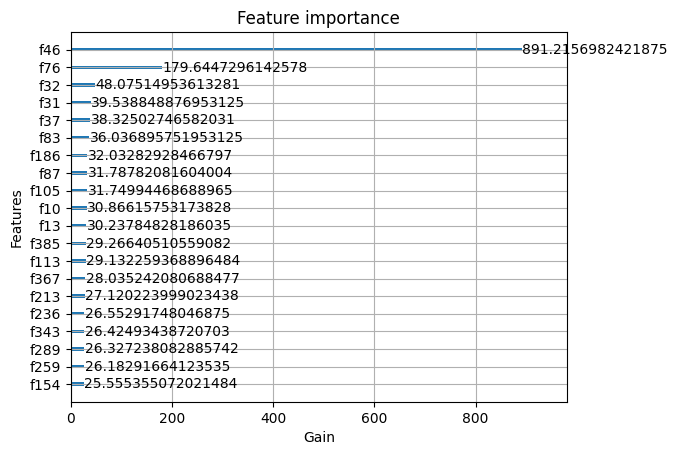

In [58]:

# Feature Importance for bagging_classifier_xgb

xgb.plot_importance(bagging_classifier_xgb.estimators_[0], max_num_features=20, importance_type="gain", xlabel="Gain")

In [103]:
bag_xgb_score = 0.9015660988341951

In [ ]:
# stacking_classifier_2 = StackingClassifier(
#     estimators=[
#         ("rfc", rfc),
#         ("xgb", xgb4_model),
#         ("hgb", hgb),
#         ("abc", abc),
#         ("bg_xgb", bagging_classifier_xgb),
#     ],
#     final_estimator=LogisticRegression(),
#     n_jobs=-1
# )

# stacking_classifier_2.fit(X_train, y_train)

# roc_auc_score(y_test, stacking_classifier_2.predict_proba(X_test)[:, stacking_classifier_2.classes_ == 1])

In [ ]:
# voting_alt_2 = VotingClassifier(
#     estimators=[
#         ("rfc", rfc),
#         ("xgb", xgb4_model),
#         ("hgb", hgb),
#         ("abc", abc),
#         ("bg_xgb", bagging_classifier_xgb),
#     ],
#     voting="soft",
#     n_jobs=-1
# )

# voting_alt_2.fit(X_train, y_train)

# roc_auc_score(y_test, voting_alt_2.predict_proba(X_test)[:, voting_alt_2.classes_ == 1])

In [ ]:
# average_classifier_3 = AverageClassifier([voting_alt_2, stacking_classifier_2])

# average_classifier_3.fit(X_train, y_train)

# roc_auc_score(y_test, average_classifier_3.predict_proba(X_test)[:, average_classifier_3.classes_ == 1])

In [ ]:
y_train[y_train == True].shape[0], y_train[y_train == False].shape[0]

(12555, 123015)

#### ROC AUC Curves

In [ ]:
models = [
    #(logistic_regression, "logistic_regression"),
    (rfc, "RandomForestClassifier"),
    (xgb1_model, "xgb1_model"),
    (xgb2_model, "xgb2_model"),
    (xgb4_model, "xgb4_model"), 
    (voting_rfc_xgb, "voting_rfc_xgb"), 
    #(gbc, "gbc"), 
    (hgb, "hgb"),
    (abc, "abc"), 
    # (etc, "etc"), 
    (voting_alt, "voting_alt"),
    # (voting_alt_2, "voting_alt_2"),
    (stacking_classifier, "stacking_classifier"),
    # (stacking_classifier_2, "stacking_classifier_2"),
    (average_classifier, "average_classifier"),
    (average_classifier2, "average_classifier2"),
    # (average_classifier_3, "average_classifier_3"),
    # (bagging_classifier_rfc, "bagging_classifier_rfc"),
    # (bagging_classifier_logistic, "bagging_classifier_logistic"),
    (bagging_classifier_xgb, "bagging_classifier_xgb"),
]

model_names = [model[1] for model in models]
models = [model[0] for model in models]

fig, ax = plt.subplots(figsize=(10, 10))

# plot_roc_curves(models, model_names, new_X_test, new_y_test, ax=ax)
plot_roc_curves(models, model_names, X_test, y_test, ax=ax)

fig.tight_layout()

NameError: name 'xgb2_model' is not defined

## Hyperopt for XGBoost Model

In [36]:
# RandomizedSearchCV for XGBClassifier

xgb_randomized_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(
        objective = 'binary:logistic',
        seed = random_state,
        n_jobs=-1,
    ),
    param_distributions={
        "n_estimators": [25, 50, 75, 100, 250, 500],
        "max_depth": [5, 10, 15, 30, 50],
        "learning_rate": [0.001, 0.01, 0.1, 0.2],
        "gamma": [0, 0.1, 0.2, 0.3, 0.4, 0.5],
        "min_child_weight": [0, 1, 2, 3, 4, 5, 6],
        "subsample": [0.5, 0.6, 0.7, 0.8, 0.9],
        "colsample_bytree": [0.5, 0.6, 0.7, 0.8, 0.9],
    },
    n_iter=100,
    scoring="roc_auc",
    n_jobs=-1,
    cv=[([t for t in range(int(X_train.shape[0] * 0.8))], [t for t in range(int(X_train.shape[0] * 0.8), X_train.shape[0])])],
    verbose=20
)

xgb_randomized_search.fit(X_train, y_train)

# xgb_randomized_search.best_params_, xgb_randomized_search.best_score_, xgb_randomized_search.best_estimator_

model = xgb_randomized_search.best_estimator_

model.fit(X_train, y_train)

score = roc_auc_score(y_test, model.predict_proba(X_test)[:, model.classes_ == 1])

notify("XGB_RAND", "Done. Score: {}".format(score))

create_submission_file(model,
                          model.get_booster().feature_names,
                          "outputs/xgb_rand: {:.5f} {}.csv".format(score, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    ) 

score

Fitting 1 folds for each of 100 candidates, totalling 100 fits
[CV 1/1; 1/100] START colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=4, n_estimators=25, subsample=0.8
[CV 1/1; 2/100] START colsample_bytree=0.7, gamma=0.1, learning_rate=0.001, max_depth=50, min_child_weight=5, n_estimators=75, subsample=0.5
[CV 1/1; 3/100] START colsample_bytree=0.8, gamma=0.3, learning_rate=0.1, max_depth=30, min_child_weight=2, n_estimators=500, subsample=0.8
[CV 1/1; 4/100] START colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=30, min_child_weight=6, n_estimators=250, subsample=0.8
[CV 1/1; 5/100] START colsample_bytree=0.6, gamma=0.4, learning_rate=0.01, max_depth=5, min_child_weight=6, n_estimators=100, subsample=0.5
[CV 1/1; 6/100] START colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.6
[CV 1/1; 7/100] START colsample_bytree=0.9, gamma=0.1, learning_rate=0.2, max_depth=15, min_child_wei

/Users/nacho/opt/anaconda3/envs/coding/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/1; 52/100] START colsample_bytree=0.7, gamma=0.3, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=500, subsample=0.9
[CV 1/1; 40/100] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=30, min_child_weight=0, n_estimators=100, subsample=0.8;, score=0.869 total time=34.6min
[CV 1/1; 53/100] START colsample_bytree=0.5, gamma=0.4, learning_rate=0.01, max_depth=15, min_child_weight=0, n_estimators=25, subsample=0.8
[CV 1/1; 50/100] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.1, max_depth=10, min_child_weight=0, n_estimators=75, subsample=0.6;, score=0.889 total time= 7.9min
[CV 1/1; 54/100] START colsample_bytree=0.7, gamma=0.5, learning_rate=0.1, max_depth=15, min_child_weight=1, n_estimators=500, subsample=0.6
[CV 1/1; 53/100] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.01, max_depth=15, min_child_weight=0, n_estimators=25, subsample=0.8;, score=0.835 total time= 3.4min
[CV 1/1; 55/100] START colsample_bytree=0.7, gamma=0.3, learn

0.9008407660123985

In [37]:
xgb_randomized_search.best_params_, xgb_randomized_search.best_score_, xgb_randomized_search.best_estimator_

({'subsample': 0.8,
  'n_estimators': 500,
  'min_child_weight': 5,
  'max_depth': 5,
  'learning_rate': 0.1,
  'gamma': 0.1,
  'colsample_bytree': 0.7},
 0.8923196517213106,
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.7, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=5, max_leaves=None,
               min_child_weight=5, missing=nan, monotone_constraints=None,
               n_estimators=500, n_jobs=-1, num_parallel_tree=None,
               predictor=None, random_state=None, ...))

In [95]:
xgb_ho_opt = xgb_randomized_search.best_estimator_

xgb_ho_opt.fit(X_train, y_train)

xgb_ho_opt_score = roc_auc_score(y_test, xgb_ho_opt.predict_proba(X_test)[:, xgb_ho_opt.classes_ == 1])

notify("XGB_RAND", "Done. Score: {}".format(xgb_ho_opt_score))

create_submission_file(xgb_ho_opt,
                          xgb_ho_opt.get_booster().feature_names,
                          "outputs/xgb_rand: {:.5f} {}.csv".format(xgb_ho_opt_score, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    ) 

xgb_ho_opt_score

0.9008407660123985

In [38]:
# Get model params
model.get_params(), score

({'objective': 'binary:logistic',
  'use_label_encoder': None,
  'base_score': None,
  'booster': None,
  'callbacks': None,
  'colsample_bylevel': None,
  'colsample_bynode': None,
  'colsample_bytree': 0.7,
  'early_stopping_rounds': None,
  'enable_categorical': False,
  'eval_metric': None,
  'feature_types': None,
  'gamma': 0.1,
  'gpu_id': None,
  'grow_policy': None,
  'importance_type': None,
  'interaction_constraints': None,
  'learning_rate': 0.1,
  'max_bin': None,
  'max_cat_threshold': None,
  'max_cat_to_onehot': None,
  'max_delta_step': None,
  'max_depth': 5,
  'max_leaves': None,
  'min_child_weight': 5,
  'missing': nan,
  'monotone_constraints': None,
  'n_estimators': 500,
  'n_jobs': -1,
  'num_parallel_tree': None,
  'predictor': None,
  'random_state': None,
  'reg_alpha': None,
  'reg_lambda': None,
  'sampling_method': None,
  'scale_pos_weight': None,
  'subsample': 0.8,
  'tree_method': None,
  'validate_parameters': None,
  'verbosity': None,
  'seed': 12

In [101]:
xgb_rs_cv_score = xgb_randomized_search.best_score_

In [102]:
xgb_cv_score, xgb_ho_score, xgb_rs_cv_score, xgb_ho_opt_score

(0.8936728115116593,
 0.8981698903861902,
 0.8923196517213106,
 0.9008407660123985)

In [108]:
bagging_classifier_xgb_w_best_params = BaggingClassifier(
    estimator=xgb.XGBClassifier(
        **xgb_randomized_search.best_params_,
        objective = 'binary:logistic',
        seed = random_state,
        n_jobs=-1,
    ),
    n_estimators=10,
    n_jobs=-1,
    verbose=20,
)

bagging_classifier_xgb_w_best_params.fit(X_train, y_train)

bagging_classifier_xgb_w_best_params_score = roc_auc_score(y_test, bagging_classifier_xgb_w_best_params.predict_proba(X_test)[:, bagging_classifier_xgb_w_best_params.classes_ == 1])

notify("BAGGING XGB", "Done. Score: {}".format(bagging_classifier_xgb_w_best_params_score))



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Building estimator 1 of 1 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...
Building estimator 1 of 2 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...
Building estimator 1 of 2 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...


[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed: 41.0min


Building estimator 2 of 2 for this parallel run (total 10)...


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed: 41.1min remaining: 123.4min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed: 41.1min remaining: 68.6min


Building estimator 2 of 2 for this parallel run (total 10)...


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed: 41.2min remaining: 41.2min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed: 41.2min remaining: 24.7min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed: 41.2min remaining: 13.7min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed: 59.0min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed: 59.0min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.0s remaining:    5.9s
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.5s remaining:    5.9s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    3.6s remaining:    3.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.6s remaining:    2.1s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    3.6s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.6s remaining:   

AttributeError: 'BaggingClassifier' object has no attribute 'get_booster'

In [114]:
create_submission_file(bagging_classifier_xgb_w_best_params,
                          xgb4_model.get_booster().feature_names,
                            "outputs/submission_bagging_xgb_best_params_polyfeat: {:.5f} {}.csv".format(bagging_classifier_xgb_w_best_params_score, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
)

bagging_classifier_xgb_w_best_params_score

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.8s remaining:    2.5s
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.8s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.9s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.2s finished


0.9025071502410601

In [ ]:
# XGBoost with Hyperopt
if hp_tune:

    xgb_space = {
        "max_depth": hp.choice("max_depth", [2, 4, 8, 16, 32, 64, 128, None]),
        "learning_rate": hp.uniform("learning_rate", 0.01, 0.2),
        "n_estimators": hp.choice("n_estimators", [10, 50, 100, 200, 500]),
        "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
        "gamma": hp.uniform("gamma", 0, 1),
        "min_child_weight": hp.choice("min_child_weight", [2, 4, 8, 16, 32, 64, 128]),
        "subsample": hp.uniform("subsample", 0.5, 1),
    }

    best_score = 0
    def objective_xgb(params):
        global best_score

        model = xgb.XGBClassifier(
            **params,
            objective = 'binary:logistic',
            seed = random_state,
            n_jobs=-1,
            #eval_metric = 'auc',
        )
        
        score = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc").mean()

        #model.fit(X_train_sub, y_train_sub, eval_set=[(X_val, y_val)], verbose=0)
        #model.fit(X_train, y_train)
        #score = roc_auc_score(y_test, model.predict_proba(X_test)[:, model.classes_ == 1])

        # print(f"Score: {score}", params)

        # if score > best_score:
        #     best_score = score
        #     print(f"New best score: {best_score}")
        #     print(params)
            
        return {"loss": 1 - score, "status": STATUS_OK}

    trials_xgb = Trials()

    best_xgb = fmin(
        fn=objective_xgb,
        space=xgb_space,
        algo=tpe.suggest,
        max_evals=100,
        trials=trials_xgb,
        verbose=2,
    )

    print(best_xgb)

In [ ]:
p = {'colsample_bytree': 0.5261530316412195, 'gamma': 0.4666423706737293, 'learning_rate': 0.043284110571295886, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 4, 'subsample': 0.8142370483321494}
model = xgb.XGBClassifier(
    **p,
    objective = 'binary:logistic',
    seed = random_state,
    n_jobs=-1,
    #eval_metric = 'auc',
)

#score = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc").mean()

model.fit(X_train, y_train)
roc_auc_score(y_test, model.predict_proba(X_test)[:, model.classes_ == 1])

Text(0.5, 1.0, 'bagging xgb holdout 0.9015660988341951')

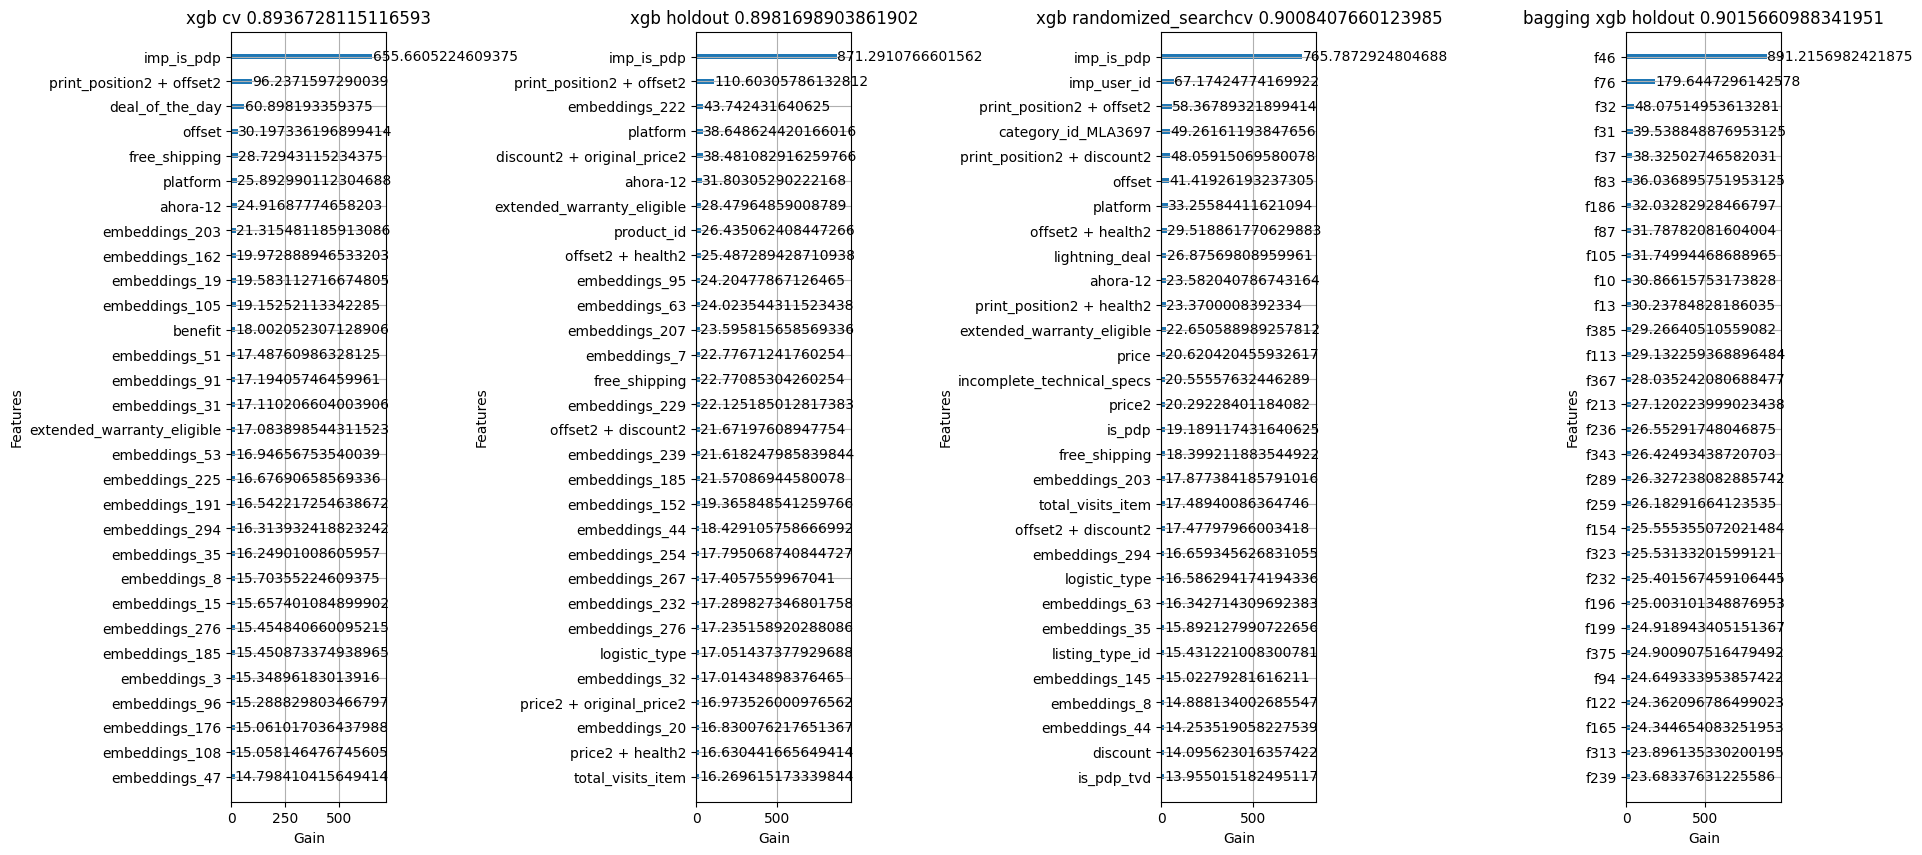

In [107]:
fig, axs = plt.subplots(1, 4, figsize=(20, 10))

feat_count = 30

xgb.plot_importance(xgb1_model, max_num_features=feat_count, importance_type="gain", xlabel="Gain", ax=axs[0])
xgb.plot_importance(xgb4_model, max_num_features=feat_count, importance_type="gain", xlabel="Gain", ax=axs[1])
xgb.plot_importance(xgb_ho_opt, max_num_features=feat_count, importance_type="gain", xlabel="Gain", ax=axs[2])
xgb.plot_importance(bagging_classifier_xgb.estimators_[0], max_num_features=feat_count, importance_type="gain", xlabel="Gain", ax=axs[3])


# Space between subplots
fig.subplots_adjust(wspace=2)

# Title for each subplot

axs[0].set_title(f"xgb cv {xgb_cv_score}".format(xgb_cv_score))
axs[1].set_title(f"xgb holdout {xgb_ho_score}".format(xgb_ho_score))
axs[2].set_title(f"xgb randomized_searchcv {xgb_ho_opt_score}".format(xgb_ho_opt_score))
axs[3].set_title(f"bagging xgb holdout {bag_xgb_score}".format(bag_xgb_score))

## Create Submission

In [ ]:
full_data["is_discount"].value_counts()

In [ ]:
# final_classifier = AverageClassifier([voting_alt_2, stacking_classifier_2])

final_classifier = AverageClassifier([voting_alt, stacking_classifier, bagging_classifier_xgb])

X_full = full_data.drop(columns=["conversion", "ROW_ID"])
X_full = X_full.select_dtypes(include='number')

y_full = full_data["conversion"]

final_classifier.fit(X_full, y_full)

# Should be 1, full_data contains test_data 
roc_auc_score(y_test, final_classifier.predict_proba(X_test)[:, final_classifier.classes_ == 1])

In [ ]:
X_test.columns

In [ ]:
roc_auc_score(y_full, final_classifier.predict_proba(X_full)[:, final_classifier.classes_ == 1])

In [ ]:
from sklearn.utils._pprint import _EstimatorPrettyPrinter

In [ ]:
import sklearn

In [ ]:
names_dif = set(X_full.columns)

for model in models:
    # if Pipeline, get last step
    if isinstance(model, sklearn.pipeline.Pipeline):
        model = model.steps[-1][1]
    
    # print feature names
    if isinstance(model, xgb.XGBClassifier):
        print(model.get_booster().feature_names)
    elif isinstance(model, VotingClassifier):
        for estimator in model.estimators_:
            if isinstance(estimator, sklearn.pipeline.Pipeline):
                estimator = estimator.steps[-1][1]
            print(estimator)
            if isinstance(estimator, xgb.XGBClassifier):
                print(estimator.get_booster().feature_names)
            #elif isinstance(estimator, HistGradientBoostingClassifier):
             #   print(estimator.feature_names_)
            #elif isinstance(estimator, GradientBoostingClassifier):
             #   print(estimator.feature_names_)
    elif isinstance(model, StackingClassifier):
        for estimator in model.estimators_:
            if isinstance(estimator, sklearn.pipeline.Pipeline):
                estimator = estimator.steps[-1][1]
            print(estimator)
            if isinstance(estimator, xgb.XGBClassifier):
                print(estimator.get_booster().feature_names)
            #elif isinstance(estimator, HistGradientBoostingClassifier):
             #   print(estimator.feature_names_)
            #elif isinstance(estimator, GradientBoostingClassifier):
              #  print(estimator.feature_names_)
    #elif isinstance(model, BaggingClassifier):
    #    print(model.base_estimator_.get_booster().feature_names)
    elif isinstance(model, HistGradientBoostingClassifier):
        #print(model.feature_names_)
        pass
    elif isinstance(model, GradientBoostingClassifier):
        # print(model.feature_names_)
        pass
    elif isinstance(model, RandomForestClassifier):
       pass



In [ ]:
feature_cols = xgb4_model.get_booster().feature_names

In [ ]:
create_submission_file(final_classifier, feature_cols, "outputs/submission_avg(bagging(xgb), voting(xgb, hgb, abc), stacking(xgb, hgb, abc)): {:.5f} {}.csv".format(score, datetime.now().strftime("%Y-%m-%d %H:%M:%S")))

#del eval_data
#del submission_df
#gc.collect()

In [ ]:
# # Save model
# import pickle

# pickle.dump(final_classifier, open("los_simuladores_avg(stack(bagging_classifier_xgb(xgb), xgb, hgb, abc), voting(xgb, hgb, abc))_full_data.pkl", "wb"))